## 1 Project Background

In the ever-changing financial markets, investors and traders are constantly on the lookout for comparable stocks that exhibit similar behavior to those they already track or invest in. While traditional stock screening tools focus on fundamental metrics such as P/E ratio, market capitalization, or sector classification, they often overlook the most intuitive form of analysis — the stock’s actual price pattern and behavior over time. 

This project aims to bridge the gap by building a price-pattern-based stock recommender system that identifies stocks with similar historical movement patterns, enabling users to discover alternatives, diversification options, and potential opportunities based purely on price action dynamics.

### 1.1 Problem
Traditional stock comparison tools rely predominantly on fundamental analysis or broad categorizations. However, investors also care about how stocks behave — their trends, volatility, and chart shapes — especially in shorter timeframes. 

There is currently a lack of intuitive tools that allow users to input a stock and receive recommendations of other stocks with similar recent performance patterns. This gap presents a problem for traders seeking behavioral substitutes, risk-aligned diversification, or pattern-based idea generation.

The main problem to be solved is to find converted features from price that capture the momentum , for example, of the different stocks and make a fair enough comprison based on a set of metrics that are not related to absolute price difference but relative price difference.

### 1.2 Project Goal
The goal of this project is to develop a stock recommender system that leverages historical price data to identify stocks with similar recent movement patterns. 

By extracting relevant features from raw price data — such as normalized returns and momentum indicators — and using similarity metrics like Euclidean distance or K-nearest neighbors (KNN), the system will output a ranked list of stocks that most closely resemble the input stock in terms of recent trend and behavior. The system will be designed to be scalable, modular, and adaptable for future extensions like technical indicator overlays, sentiment analysis, and personalized recommendations for future development.

## 2 Data
### 2.1 Data Citation & Description

The stock price data used in this project is obtained via the Yahoo Finance API through the yfinance Python library. Yahoo Finance is a widely-used and reputable source for historical market data, offering open access to daily stock prices, trading volume, and other market indicators.

The data includes the following fields for each stock ticker:

- Date: Trading date

- Open: Price at market open

- High: Highest trading price of the day

- Low: Lowest trading price of the day

- Close: Price at market close

- Volume: Total number of shares traded

This raw data will be preprocessed into derived features representing the relative rate of change over different rolling windows to capture the overall behavior and trend of the stock’s recent performance.

### 2.2 Data Details and Derived Features
To capture temporal price action patterns in a structured and quantifiable form, I implemented a sliding window framework that frame historical market data into fixed-length segments, or "windows", of user-defined length in days.This sliding window wil shift by a user defined values as step of days. For each window, a set of engineered features is extracted to summarize the relative movement, volatility, and structural behavior of price and volume across the given time frame.

The core idea is to transform raw price data (i.e. Open, High, Low, Close, Volume) within each window into numerical indicators that represent both overall directional change and intra-window dynamics. This transformation enables downstream tasks such as similarity comparison, clustering, or predictive modeling based on comparable vectorized representations.

#### For Each Historical Window:

    Overall Relative Change 

Features are computed by comparing the first and last values of each price/volume series. This captures the net movement direction and amplitude over the window. For example, (close_last - close_first) / close_first gives the net return over the window.

    Relative Extremes 

It is calculated as the deviation of the maximum and minimum values from the mean, normalized by the mean. These features capture volatility and asymmetry in the price behavior, independent of absolute levels.

    Pairwise Day-to-Day Change 

Metrics are used to measure the average relative change between consecutive days within the window. This provides an internal measure of smoothness or turbulence in price/volume action over the window.

    Candle Body Ratio 

It is defined as the average of the body-to-range ratio over all days in the window, where the body is abs(close - open) and the full range is high - low. This metric reflects how much of the daily range is actually covered by the directional move, offering insight into the strength of daily trends.

    Pairwise Candle Body Change 

It tracks the relative change in candle body size across days, quantifying the fluctuation in market momentum or pressure.


These engineered features will form the input vectors for the unsupervised learning model, which will use KNN or cosine similarity to determine the closest matches in behavior among a universe of stocks. This transformation from raw prices to trend-based features ensures that the system captures meaningful pattern similarities rather than absolute price levels. 

## 3 Data Extraction and Cleaning
### <span style="color:rgba(109, 0, 0, 1)">3.1 Reasons for cleaning </span>

Although data retrieved from Yahoo Finance via the yfinance API is generally reliable and well-structured, several important data cleaning steps are required to ensure the consistency and validity of the analysis:

##### a. Incomplete Historical Coverage

Some stocks in the dataset may have been listed on the market for a period shorter than the analysis window (e.g., less than 120 trading days). These stocks will have missing or insufficient data points, especially in rolling-return or momentum calculations, resulting in NaN values. These entries will be excluded to maintain uniformity in feature vectors and avoid skewing similarity results.

##### b. Null or Missing Values

Occasionally, due to trading halts, data delays, or new listings, certain tickers may have null values for one or more price fields (e.g., Close, Volume). These rows will be dropped or imputed with care, depending on the context, but for similarity analysis, stocks with incomplete data in the analysis window will be removed entirely to maintain clean distance calculations.

##### c. Exclusion of ETFs and Derivative Products

The focus of this project is on individual equity stocks, not ETFs, funds, or derivative instruments. Many ETFs mimic the behavior of an index or basket of stocks and may introduce artificial similarity due to averaging effects. Therefore, tickers identified as ETFs or non-stock instruments (e.g., those containing “ETF”, “Fund”) will be filtered out from the recommendation.

##### d. Duplicate or Suspended Tickers

Some tickers may be deprecated, duplicated (e.g., due to mergers or renaming), or no longer actively traded. These will be identified by checking for zero trading volume over recent periods or constant price values, and will be removed to avoid noise in the similarity engine.


### <span style="color:rgba(109, 0, 0, 1)">3.2 Data from yfinance </span>

Importing Library for use

In [1]:
import requests
from io import StringIO
import csv
import math

import pandas as pd
import numpy as np

import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_distances

The ticker "AAPL" below is used to simply test the functions.
The following cleaning steps have been taken in the functions:

1. Removed all rows with missing values using dropna()

2. Performed linear interpolation to fill in small gaps using interpolate(method='linear')

3. Removed duplicate rows based on datetime index

4. Reset the index to convert the datetime index into a standard column using

5. Sorted the data chronologically by the 'Date' column

6. Converted datetime values to plain dates (i.e. 2025/06/11)



In [2]:
# Function to fetch and clean stock data
def fetch_clean_data(ticker_symbol, period="120d", interval="1d"):
    # Fetch Data from Yfinance
    ticker = yf.Ticker(ticker_symbol)
    data = ticker.history(period=period, interval=interval)
    
    #Clean Data
    data.dropna(inplace=True)
    data.interpolate(method='linear', inplace=True)

    # Remove Duplicates
    data = data[~data.index.duplicated(keep='first')]
    data = data.astype(float)
    
    # Reset Index and Convert Date
    data = data.reset_index()
    data['Date'] = pd.to_datetime(data['Date'])

    return data 

# Function to sort DataFrame by Date
def sort_by_date(df):
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    return df.sort_values('Date').reset_index(drop=True)

# To define vraibales
ticker= "AAPL"
total_lookback_days = '120d'

# Fetch and clean data
df = fetch_clean_data(ticker, period = total_lookback_days, interval="1d")
df = sort_by_date(df)

print (f'Shape of data {df.shape}')
print (df.head(5))

Shape of data (120, 8)
         Date        Open        High         Low       Close       Volume  \
0  2025-04-09  171.530131  200.120153  171.470280  198.364456  184395900.0   
1  2025-04-10  188.608353  194.304402  182.553167  189.955048  121880000.0   
2  2025-04-11  185.645589  199.052758  185.605678  197.666153   87435900.0   
3  2025-04-14  210.923715  212.420052  200.668818  202.025497  101352900.0   
4  2025-04-15  201.367108  203.013073  199.312141  201.646423   51343900.0   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  


### <span style="color:rgba(109, 0, 0, 1)">3.3 Retrive all relevant tickers available </span>

Get all the relevant tickers string from NASDAQ online text document.

The following actions has been taken to clean the unecessary data:

1. Referring to the "reasons for cleaning" point c, ETFs and derived products should be removed

2. Tickers with lid symbols are being disregarded


In [3]:
# Function to get all US equity tickers from NASDAQ
def get_us_equity_tickers():
    urls = [
        ("https://www.nasdaqtrader.com/dynamic/SymDir/nasdaqlisted.txt", "Symbol"),
        ("https://www.nasdaqtrader.com/dynamic/SymDir/otherlisted.txt", "ACT Symbol")
    ]

    tickers = []

    for url, symbol_col in urls:
        r = requests.get(url)
        content = r.text.split("File Creation Time")[0]
        df = pd.read_csv(StringIO(content), sep="|")
        
        #Filter out ETFs and Test Issues if those columns exist
        if "ETF" in df.columns:
            df = df[df["ETF"] != "Y"]

        if "Test Issue" in df.columns:
            df = df[df["Test Issue"] != "Y"]

        tickers.extend(df[symbol_col].tolist())

    return list(set(tickers))

# Function to clean tickers based on specific criteria
def clean_lid_symbol(symbol):
    if not isinstance(symbol, str):
        return False
    return (
        "$" not in symbol and
        "^" not in symbol and
        "=" not in symbol and
        ".U" not in symbol and
        ".W" not in symbol and
        "." not in symbol and
        ".P" not in symbol
    )

# Fetch and clean tickers
tickers = get_us_equity_tickers()
tickers = [s for s in tickers if clean_lid_symbol(s)]

print (f"Total tickers fetched: {len(tickers)}")
print (f'First 10 tickers: {tickers[:10]}')

Total tickers fetched: 6766
First 10 tickers: ['YMT', 'ABNB', 'TRML', 'VNET', 'KALU', 'TM', 'VPV', 'CCCX', 'ASTE', 'CELUW']


### <span style="color:rgba(109, 0, 0, 1)">3.4 Compute Derived Parameters </span>

Below is a feature engineering pipeline that transforms stock price data into structured, interpretable metrics using a sliding window approach (window_size) 

For each fixed-length window (e.g., 15 trading days), the following features are computed:

1. Overall Relative Change

2. Relative Extremes

3. Pairwise Day-to-Day Change

4. Candle Body Ratio

5. Pairwise Candle Body Change

Each of these features is computed per window and can be scaled across multiple windows depending on the total number of lookback days and the size of each window. This makes the feature set highly adaptive and configurable for different time horizons defined by user.

----

#### User-Defined Parameters

    partition_days

Number of days in each analytical sliding window (e.g., 15 days)

    step_shift_days

Number of days as step between consecutive windows (e.g. 5 days)

    total_lookback_days

The total amount of days to be analyzed (e.g. 120 days)

The result is a fixed-length feature vector that summarizes structural price characteristics over defined time windows, suitable for machine learning, clustering, or similarity analysis.

In [4]:
# Main function to compute features over sliding windows
def compute_sliding_window_features(df, shift_days, partition_days):
    total_length = len(df)
    
    df_parts = []
    for i in range(int(total_length/shift_days)):
        part = df[i*shift_days:i*shift_days+partition_days]
        if (len(part)) != partition_days:
            continue
        df_parts.append(part)
    
    combined_result = {}
    for i,df_concerned in enumerate(df_parts):
        combined_result.update(derive_relative_change_features(df_concerned, i+1))
        combined_result.update(compute_candle_ratio(df_concerned, i+1))

    return pd.DataFrame([combined_result])

# Function to derive relative change features
def derive_relative_change_features(df_concerned, part_ID):
   result = {}
   close = df_concerned['Close']
   open = df_concerned['Open']
   high = df_concerned['High']
   low = df_concerned['Low']
   volume = df_concerned['Volume']
   length = df_concerned.shape[0]

   # Overall Metric over the entire window
   names = ['close', 'open', 'high', 'low','volume']
   price_data = [close, open, high, low, volume]
   for name,data in zip(names, price_data):
    mean = data.mean()
    min = data.min()
    max = data.max()
    result[f'price_overall_{name}_change_portion_{part_ID}'] = (data.iloc[-1] - data.iloc[0]) / data.iloc[0]
    result[f'price_overall_{name}_relative_max_portion_{part_ID}'] = abs(max-mean)/mean
    result[f'price_overall_{name}_relative_min_portion_{part_ID}'] = abs(min-mean)/mean

    # Pairwise metric every 2 days
    for name, data in zip(names, price_data):
        pairwise_percent_change = []
        for i in range(length-1):
            change = (data.iloc[i + 1] - data.iloc[i]) / data.iloc[i]
            pairwise_percent_change.append(change)
        if len(pairwise_percent_change) != 0:
            result[f'price_pairwise_{name}_mean_portion_{part_ID}'] = sum(pairwise_percent_change) / len(pairwise_percent_change)
        else:
            result[f'price_pairwise_{name}_mean_portion_{part_ID}'] = 0.0

   return result

# Function to compute candle ratio features
def compute_candle_ratio(df_concerned, part_ID):
    result = {}
    close = df_concerned['Close']
    open = df_concerned['Open']
    high = df_concerned['High']
    low = df_concerned['Low']
    length = df_concerned.shape[0]
    
    body_size = abs(close - open)
    full_range = high - low
    body_to_range_ratio = body_size / full_range
    result[f'candle_body_ratio_portion_{part_ID}'] = body_to_range_ratio.mean()
    
    # Pairwise Candle Body Change
    pairwise_body_change = []
    for i in range(length - 1):
        prev = body_size.iloc[i]
        curr = body_size.iloc[i+1]
        if prev != 0:
            change = (curr - prev) / prev
            pairwise_body_change.append(change)
    if pairwise_body_change:
        result[f'candle_pairwise_body_change_mean_{part_ID}'] = sum(pairwise_body_change) / len(pairwise_body_change)

    return result

_partition_days = 15
_step_shift_days = 5

# Compute derived features
ticker_vector = compute_sliding_window_features(df, shift_days = _step_shift_days, partition_days = _partition_days)

print (ticker_vector.shape)
print (ticker_vector.isnull().sum().sum())
print (f'Ticker Vector Shape: {ticker_vector.shape}')
print (f'First 5 Column Names: {list(ticker_vector.columns[:5])}')


(1, 484)
0
Ticker Vector Shape: (1, 484)
First 5 Column Names: ['price_overall_close_change_portion_1', 'price_overall_close_relative_max_portion_1', 'price_overall_close_relative_min_portion_1', 'price_pairwise_close_mean_portion_1', 'price_pairwise_open_mean_portion_1']


### <span style="color:rgba(109, 0, 0, 1)">3.5 Apply on all tickers </span>

THis section automates the process of generating a structured dataset of engineered features for multiple stock tickers using a sliding window approach. The output is written row-by-row to a CSV file, allowing efficient memory usage and scalability across large ticker sets.

It involves the following steps:

1. Data Fetching and Cleaning

2. Feature Extraction

3. CSV Writing

- Each fetched ticker price data will be saved individually, such that it will not be necessary to run through yfinanace next time (it is 10+ mins running process)
- After running all the function, a csv file containing all the engineered features for each ticker will be saved.

In [5]:
# Create output CSV and write header
def ticker_matrix_creation(tickers,analysis_days_split,_period= 120,_interval = '1d',local_run = False,output_file = "data/ticker_matrix.csv"):
    _period = str(_period+10) + 'd'
    open(output_file, mode='w').close()
    header_written = False
    
    # Iterate through each ticker, fetch data, compute features, and write to CSV
    for ticker in tickers:
        if local_run == False:
            df = fetch_clean_data(ticker, period=_period, interval=_interval)
            df = sort_by_date(df)
            path = f"data/{ticker}.csv"
            df.to_csv(path)
        else:
            try:
                df = pd.read_csv(f"data/{ticker}.csv", index_col=0, parse_dates=True, date_format="%Y-%m-%d %H:%M:%S%z", nrows=_period)
                df = df[:int(_period.split('d')[0])]
            except:
                continue
        
        # Compute features with error handling for invalid operations
        with np.errstate(invalid='ignore', divide='ignore'):
            ticker_df = compute_sliding_window_features(df, shift_days = _step_shift_days, partition_days = _partition_days)
        
        headers = ['Ticker']  + ticker_df.columns.tolist()
        vector = ticker_df.values[0]
        
        # Write to CSV
        with open(output_file, mode='a', newline='') as f:
            writer = csv.writer(f)
            if header_written == False:
                writer.writerow(headers)
                header_written = True
            writer.writerow([ticker] + vector.tolist())

# Create ticker subset matrix by defining analysis windows in days. To evaluate the approach
_local_run = False # True if running locally with pre-downloaded data, False to fetch from yfinance
analysis_days_split = 15
_step_shift_days = 5
total_lookback_days = 120

# Create full ticker matrix
file_name = "data/full_ticker_matrix.csv"

#ticker_matrix_creation(tickers,analysis_days_split,_period = total_lookback_days,_interval= '1d',local_run = _local_run, output_file = file_name)

print (f"Full Ticker matrix creation completed file saved: {file_name}")


Full Ticker matrix creation completed file saved: data/full_ticker_matrix.csv


Code to retrieve the engineered feature matrix and cleaning is done to drop the rows with null values if any.

In [6]:
# Convert all columns except 'Ticker' to float
def clean_ticker_matrix(df):
    df.update(df.drop(columns="Ticker").astype(float))
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    return df

# Retrieve and clean the engineered feature matrices
full_ticker_matrix = pd.read_csv("data/full_ticker_matrix.csv")

# Clean the matrices
full_ticker_matrix = clean_ticker_matrix(full_ticker_matrix)

print (full_ticker_matrix.shape)

(5416, 529)


### <span style="color:rgba(109, 0, 0, 1)">3.6 Cleaning Summary</span>
The following steps outline the data acquisition, cleaning, feature derivation, and matrix construction process used to generate a clean feature matrix of US equity tickers:

#### Ticker Extraction and Filtering

Tickers were fetched from the NASDAQ and other listed sources using

https://www.nasdaqtrader.com/dynamic/SymDir/nasdaqlisted.txt

https://www.nasdaqtrader.com/dynamic/SymDir/otherlisted.txt

Filtering criteria
- Exclusion of ETF-related tickers (ETF != Y)
- Removal of test issues (Test Issue != Y)
- Removal of malformed or special-format tickers using custom sanitization (clean_symbol()), excluding symbols containing $, ^, =, .U, .W, .P, or any period.

#### Historical Price Data Cleaning
Historical price data for a ticker is retrieved using yfinance over a time window of 120 trading days at a daily interval.

- Remove rows with NaN values (dropna)
- Apply linear interpolation to fill small missing gaps (interpolate)
- Remove duplicate timestamps
- Ensure all data is of numeric type
- Reset index and convert timestamp to date only

#### Date Standardization

- Dates are standardized and sorted using sort_by_date()
- Ensures ascending chronological order and consistent date format across all tickers

#### Windowed Feature Extraction
- The 120-day data is partitioned into overlapping sliding windows of 15 days each with 5 days step
- Derived features computed: Relative Change Features, Candle Ratio Features
- All computed features are uniquely tagged with window ID (portion_1, ..., portion_50), resulting in 484 features per ticker

#### Ticker Matrix Construction
- Data for each ticker is processed and features are saved row-by-row to a CSV file to avoid memory overload.
- Local mode allows reading from pre-downloaded CSVs instead of querying yfinance online.

    Final matrix
- Shape: (5331, 485) → 5331 tickers × 484 features + 1 Ticker column
- All feature columns are converted to float
- Any rows with NaN values are dropped


### <span style="color:rgba(109, 0, 0, 1)">3.7 Conclusion & Discussion</span>

- The data extraction and cleaning process successfully produced a robust and clean dataset comprising 5331 US equity tickers, each represented by 484 derived numerical features based on 120 days of historical trading data and sliding window of 15 days with 5 days step in-between. 

- The approach ensured a consistent and standardized format suitable for quantitative analysis, machine learning modeling, or investment screening.

- Writing to disk incrementally allowed efficient handling of large-scale data without exceeding memory constraints.

- This pipeline is scalable, modular, and can be easily extended to incorporate extra metrics like intraday intervals, alternative financial metrics, or global exchanges.

- Multi-resolution temporal windows could be applied (currently applied 15-days sliding window)


## 4 Exploratory Data Analysis (EDA)
### <span style="color:rgba(109, 0, 0, 1)">4.1 Distribution Analysis</span>

This notebook performs exploratory data analysis (EDA) on engineered  features extracted from sliding windows over financial price and volume data. The goal is to understand the statistical distribution of each feature type across all time windows, detect skewness, and identify potential outliers that may affect downstream modeling.

The following has been done given the large amount of features:

- Feature columns are groups in the dataset that share the same feature type across different time window portions (e.g., close_change_portion_1 to close_change_portion_8)

- Stacks the values of each feature type across all windows into a single array to analyze its overall statistical behavior, independent of time slice.

- Plots histograms with KDE overlays for each feature group to visually assess distribution shape, skewness, and the presence of long tails or extreme values.


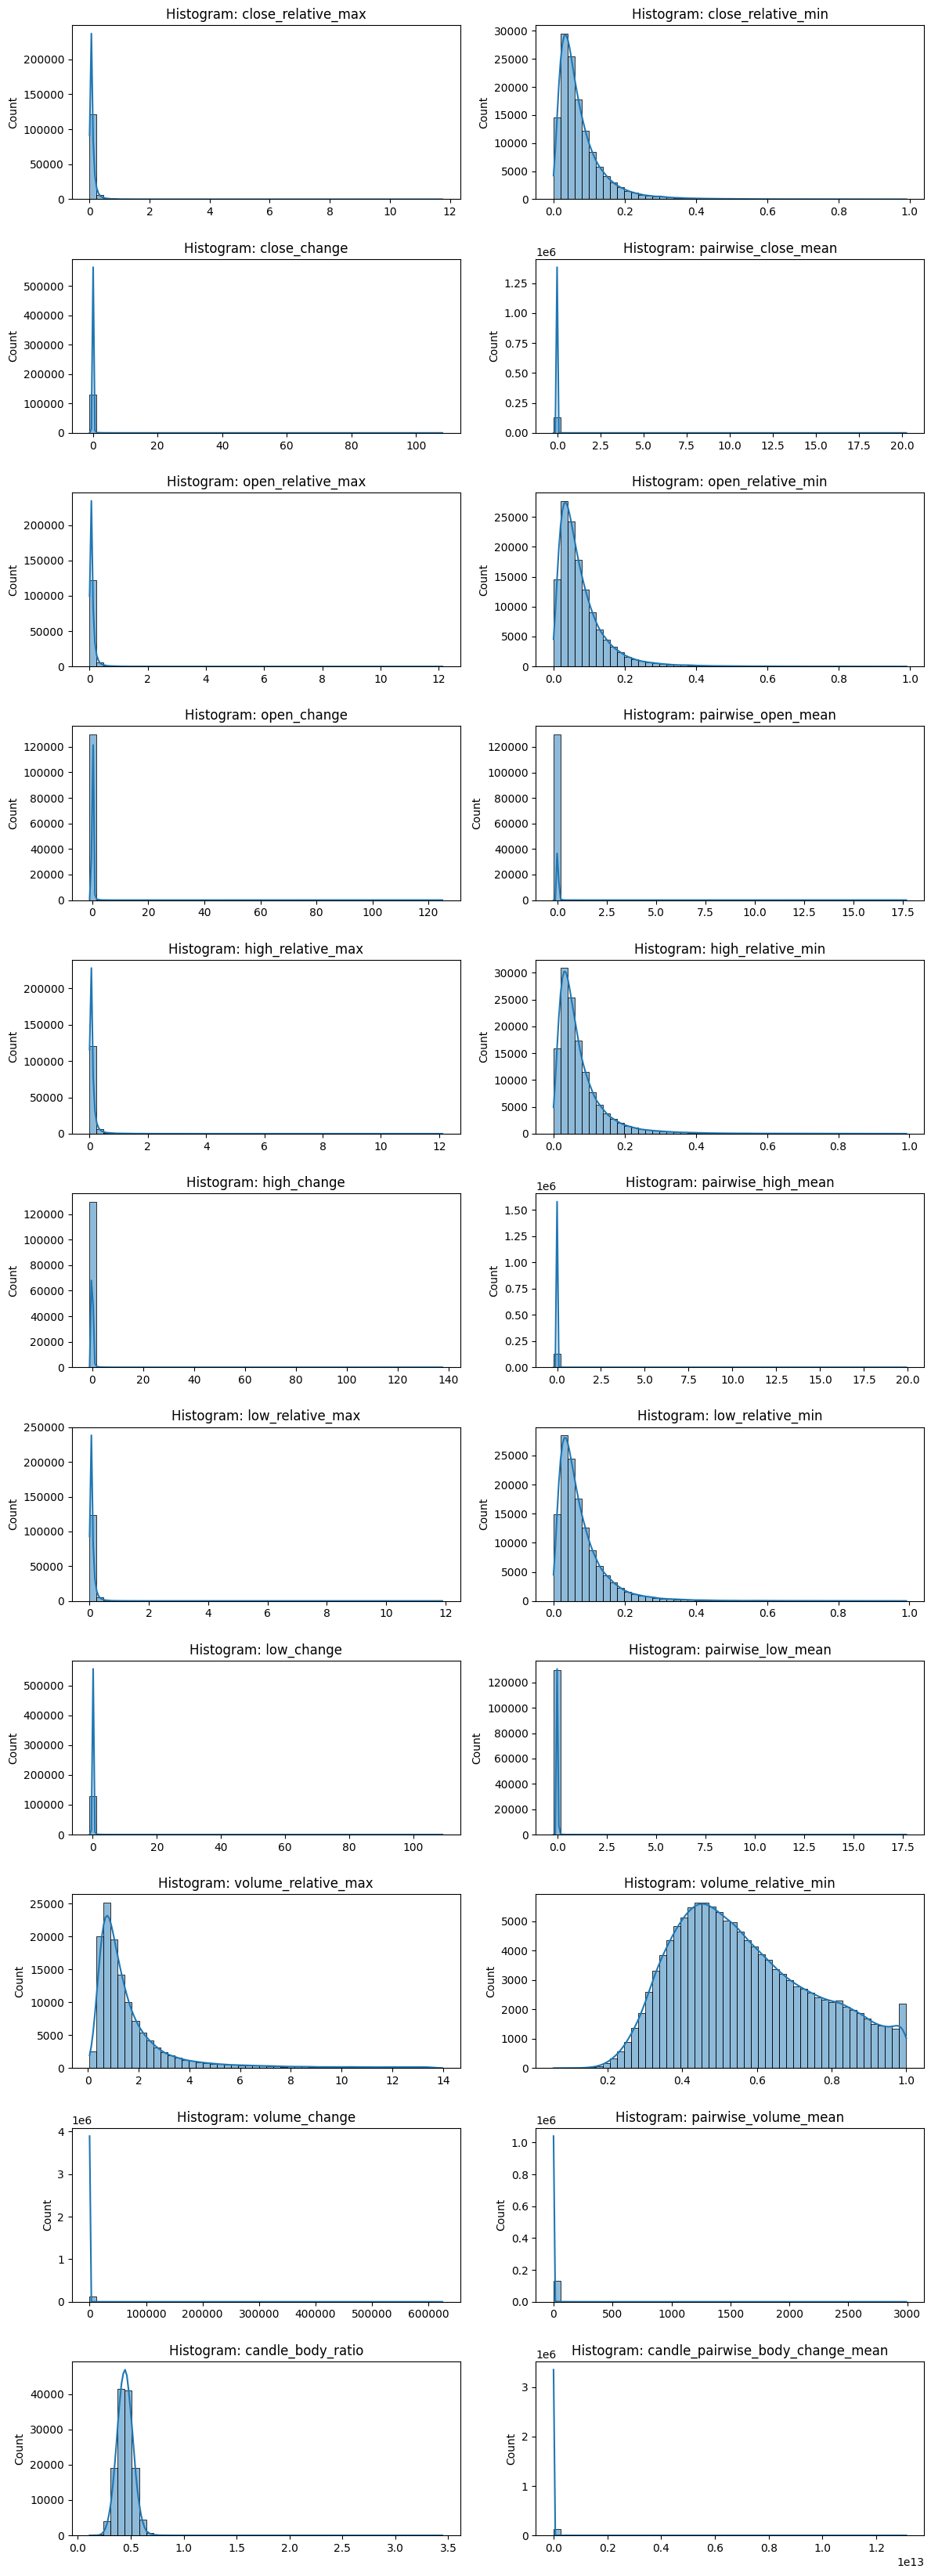

In [7]:
# Define feature key names
def get_feature_key_names():
    types = ["close", "open", "high", "low", "volume"]
    feature_key_names = []
    for category in types:
        feature_key_names.append(f'{category}_relative_max')
        feature_key_names.append(f'{category}_relative_min')
        feature_key_names.append(f'{category}_change')
        feature_key_names.append(f'pairwise_{category}_mean')
    feature_key_names.append('candle_body_ratio')
    feature_key_names.append('candle_pairwise_body_change_mean')
    return feature_key_names

# Group features by their key names
def get_grouped_features(df, feature_key_names):
    grouped_features = []
    for i,key in enumerate(feature_key_names):
        sample_features = [col for col in df.columns if key in col]
        grouped_features.append(sample_features)
    
    # flatten the list of lists
    grouped_features = [item for sublist in grouped_features for item in sublist]
    
    return grouped_features

# log-transform features and clip outliers
def log_transform_and_clip(df, columns):
    for col in columns:
        df[col] = np.log1p(df[col])
        lower, upper = df[col].quantile([0.01, 0.99])
        df[col] = df[col].clip(lower, upper)
    return df

# Stack feature values for visualization
def get_stack_feature_values(df, grouped_features, feature_key_names):
    stack_feature_values = []
    for sample_features,key in zip(grouped_features,feature_key_names):
        # Get the features for the specific key (stacked across all sliding windows)
        sample_features = [col for col in df.columns if key in col]
        stacked_values = df[sample_features].values.flatten()
        stacked_values = stacked_values[~pd.isnull(stacked_values)]
        stack_feature_values.append(stacked_values)

    return stack_feature_values

# Plot histograms for all features
def plot_histograms(stack_feature_values, feature_key_names):
    n_cols = 2
    n_rows = (len(stack_feature_values) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 3))
    axes = axes.flatten()

    for i, values in enumerate(stack_feature_values):
        sns.histplot(values, kde=True, bins=50, ax=axes[i])
        axes[i].set_title(f"Histogram: {feature_key_names[i]}")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Stack feature values across sliding windows and plot histograms
full_df = full_ticker_matrix.copy()
feature_key_names = get_feature_key_names()
grouped_features = get_grouped_features(full_df, feature_key_names)

stack_feature_values = get_stack_feature_values(full_df, grouped_features, feature_key_names)
plot_histograms(stack_feature_values, feature_key_names)


The analysis addresses the issue of skewed feature distributions caused by extreme values or high concentration around specific ranges. Most of the engineered features, especially financial ratios and changes, exhibited non-Gaussian behavior with heavy tails or sharp peaks.

The following code is trying to correct skewness and outliners by

- a logarithmic transformation (log1p) is used to compress the scale of large values and reduce right-skewness, ensuring better symmetry in the distribution.

- clipping at the 1st and 99th percentiles helps remove the influence of outliers without completely discarding data points, improving robustness for downstream learning tasks.


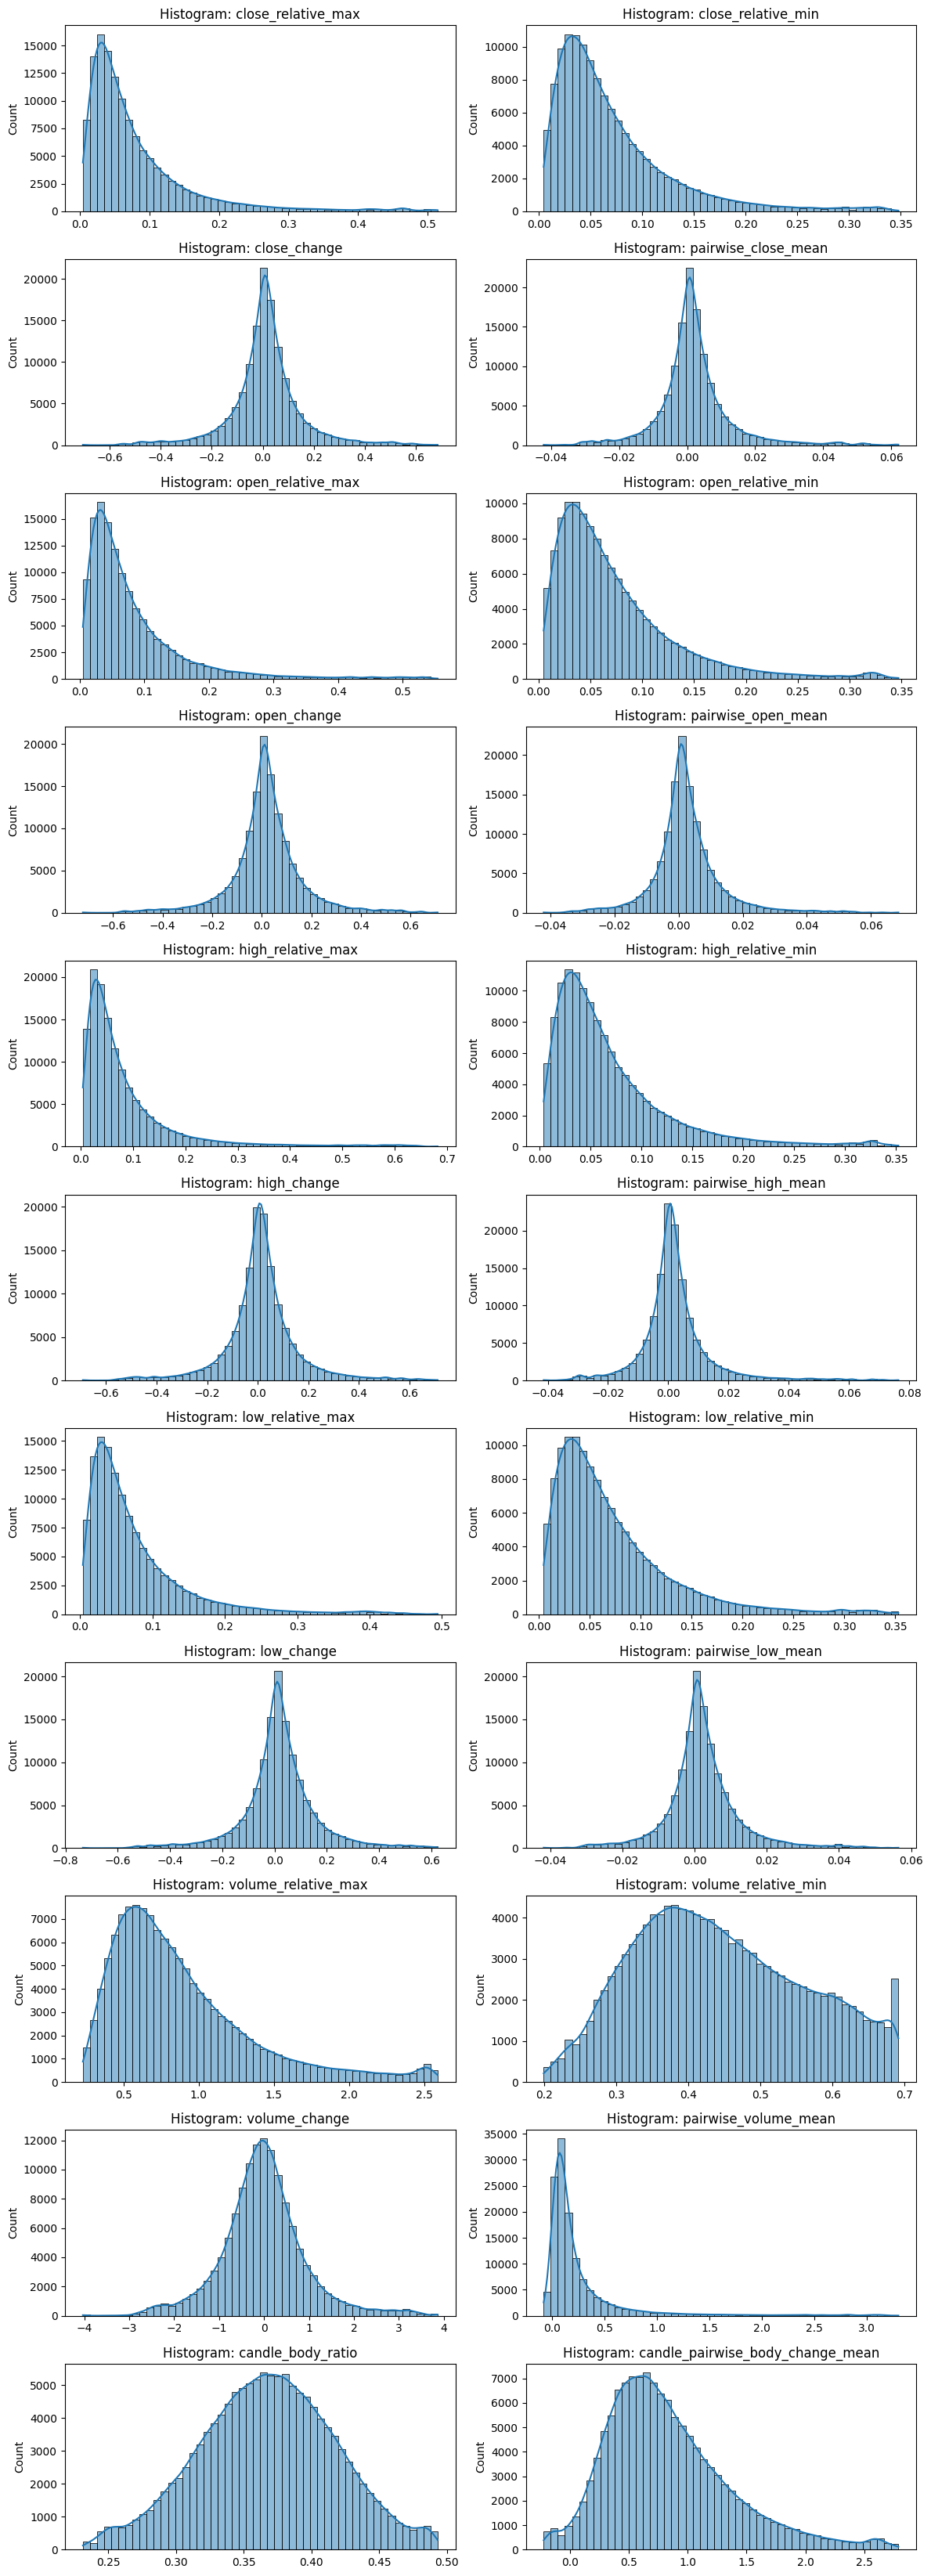

In [8]:
# log-transform features and clip outliers
def log_transform_and_clip(df, columns, epsilon=1e-8):
    for col in columns:
        df[col] = np.log1p(df[col] + epsilon)
        lower, upper = df[col].quantile([0.01, 0.99])
        df[col] = df[col].clip(lower, upper)
    return df

# Stack feature values across sliding windows and plot histograms
full_df = full_ticker_matrix.copy()
feature_key_names = get_feature_key_names()
grouped_features = get_grouped_features(full_df, feature_key_names)

# Log-transform and clip outliers
full_df = log_transform_and_clip(full_df, grouped_features)

stack_feature_values = get_stack_feature_values(full_df, grouped_features, feature_key_names)
plot_histograms(stack_feature_values, feature_key_names)

### <span style="color:rgba(109, 0, 0, 1)">4.2 Correlation Matrix</span>

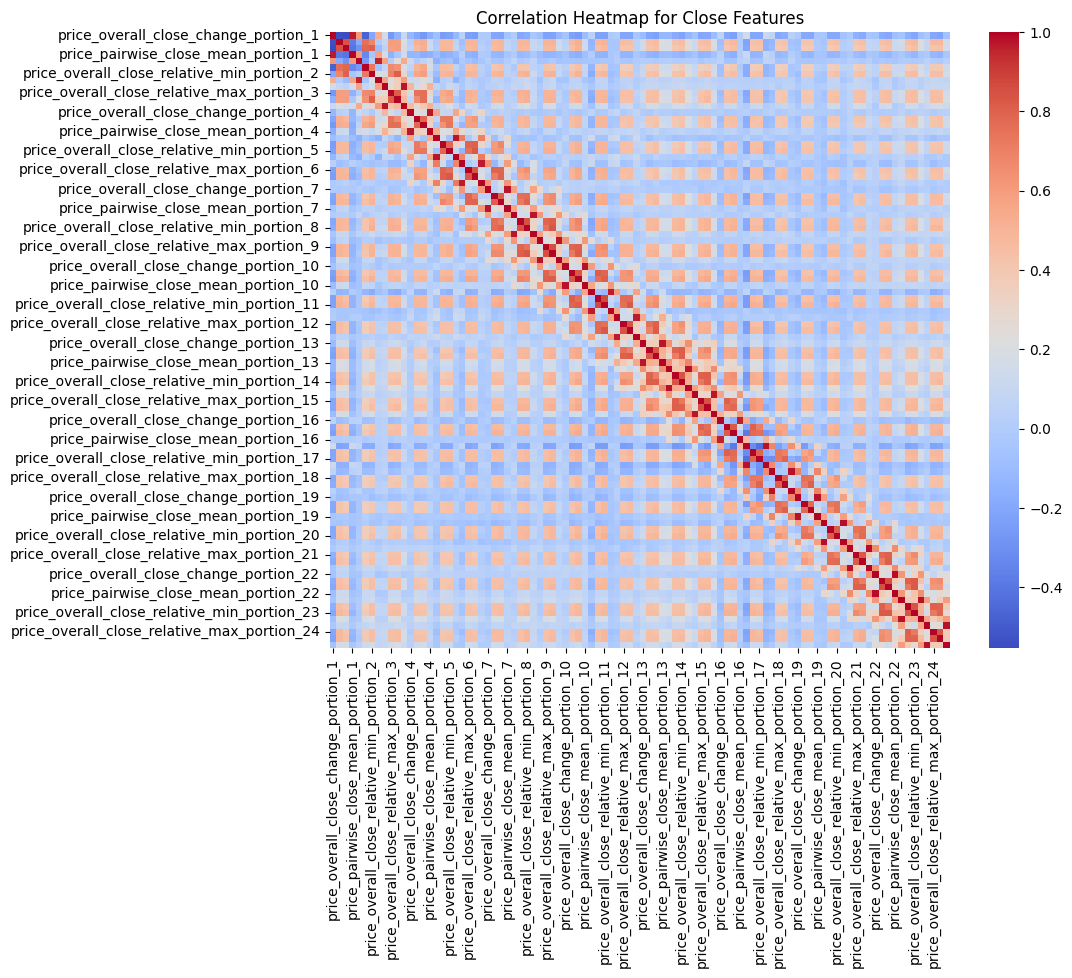

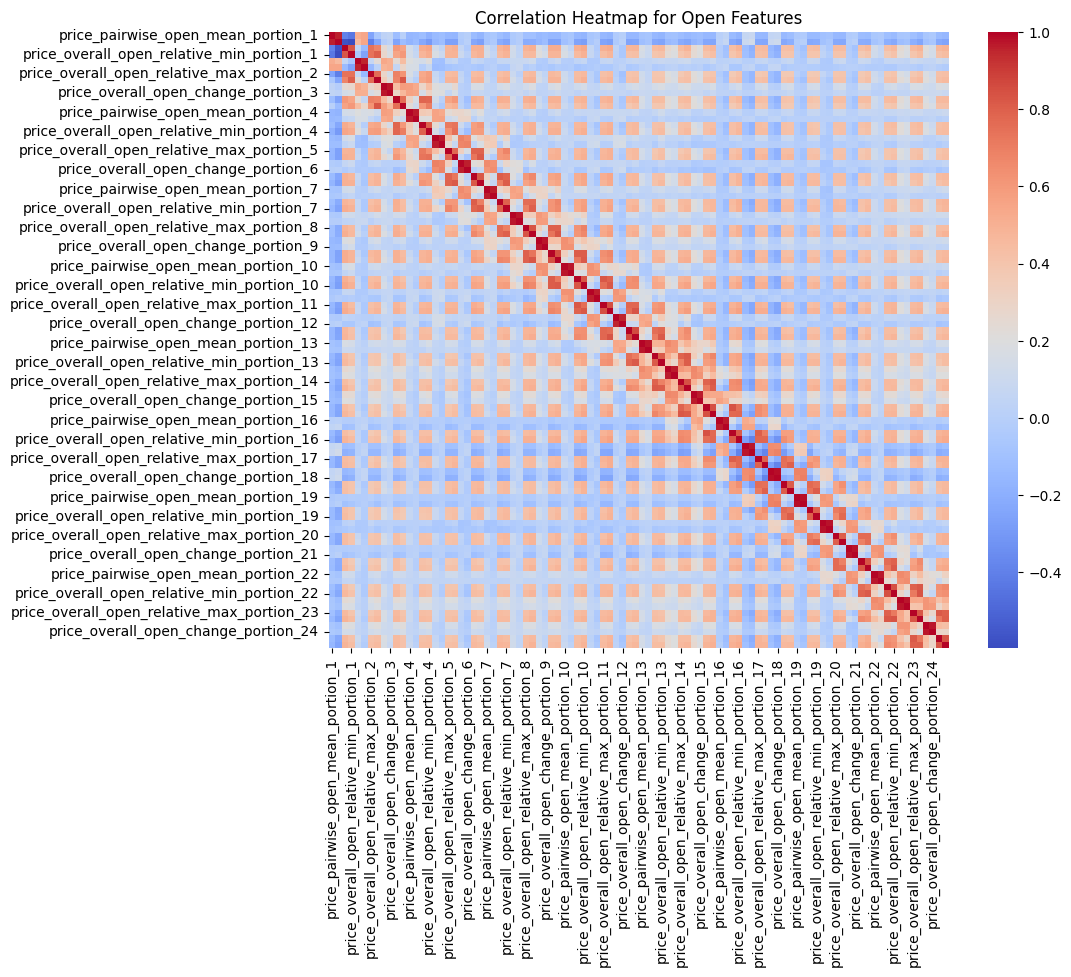

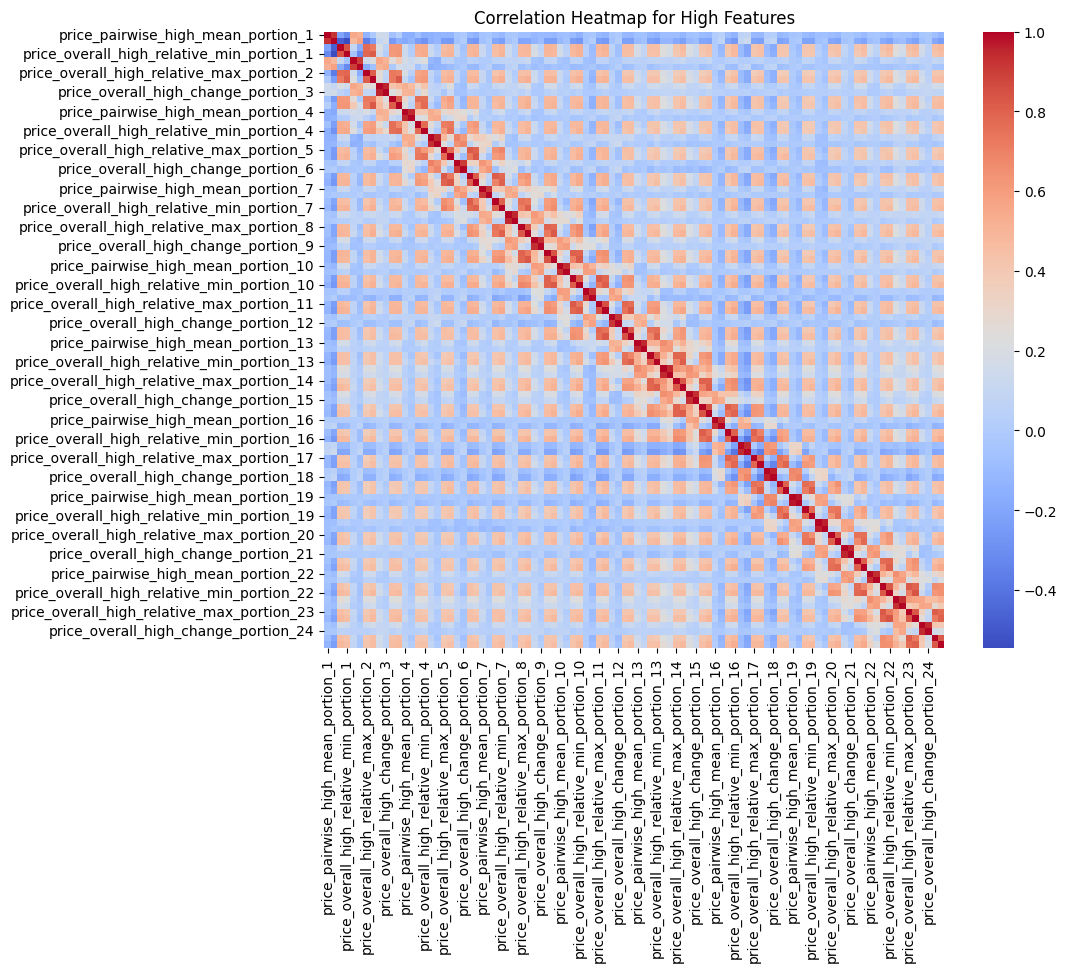

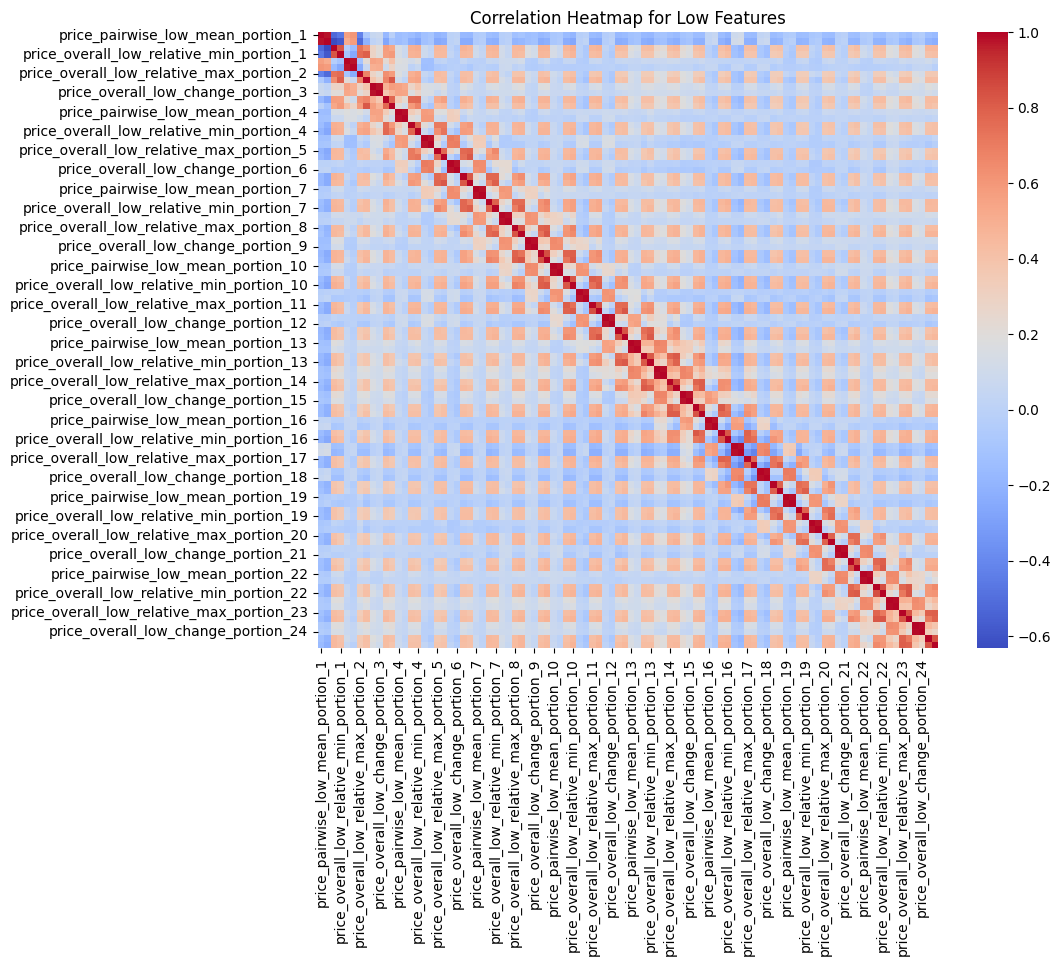

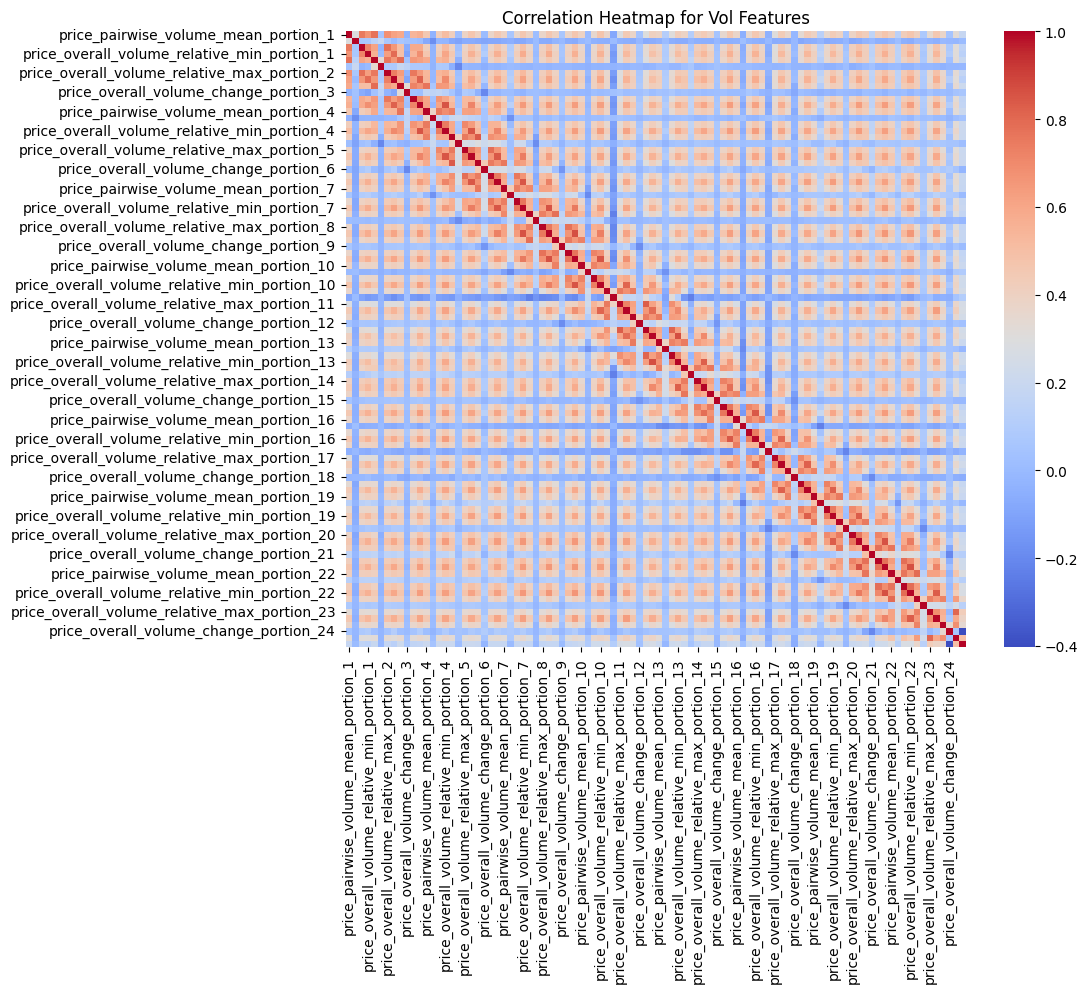

In [9]:
categories = ["close", "open", "high", "low", "vol"]

for category in categories:
    features = [col for col in full_df.columns if category in col]
    corr_matrix = full_df[features].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
    plt.title(f"Correlation Heatmap for {category.capitalize()} Features")
    plt.show()


This correlation heatmap visualizes the relationships among close-related features across multiple sliding window portions. As expected, features within the same time window (portion) show strong positive correlations, particularly between close_change, relative_max, relative_min, and pairwise_mean. This is reasonable, as these metrics are all derived from the same underlying price movement within a localized temporal context.

#### Observations

    Diagonal block patterns

Each block of 4 features from the same portion forms a tight red square, indicating high within-window correlation. This confirms that features constructed from the same time window exhibit similar behavior.

    Relatively lower correlation across different window portions

Features from different window portions are generally more weakly correlated, especially between distant time windows


    Pairwise close mean

This feature tends to correlate well with both relative_min and relative_max, showing that it captures some of the same dynamics, possibly acting as a smoother or average signal of local volatility.



### <span style="color:rgba(109, 0, 0, 1)">4.4 Summary of EDA Analysis</span>

This exploratory data analysis (EDA) focuses on engineered time-series features derived from sliding windows over financial market data. The analysis is designed to inspect the statistical distribution, detect skewness, and assess correlation relationships among features across multiple temporal slices. The approach includes feature grouping, transformation, and visualization.

- Feature Key Definitions 

A set of consistent feature key names is defined for categories such as close, open, high, low, and volume, including transformations like relative_max, relative_min, change, and pairwise_mean. Additional technical indicators like candle_body_ratio are also included.

- Grouping Across Windows

Features are grouped by their key names across all sliding windows. This allows stacking the same type of feature (e.g., close_change) from different windows (portion_1 to portion_22) into a single distribution for unified analysis.

- Log Transformation & Clipping

To resolve skewed distributions and suppress outliers, a log1p transformation is applied, followed by clipping values between the 1st and 99th percentiles. This improves distribution symmetry and reduces the influence of extreme values.

- Distribution Visualization

All features are stacked and visualized using histograms with overlays to inspect their overall distribution shapes, skewness, and outlier behavior across time.



### <span style="color:rgba(109, 0, 0, 1)">4.5 Conclusion & Discussion</span>

This EDA confirms that the engineered time-series features across sliding windows are structurally well-formed and carry meaningful statistical properties. Most features exhibit heavy skewness or outlier sensitivity due to the nature of financial data, which was effectively mitigated through log transformation and percentile-based clipping. Histogram visualizations revealed that transformed features are more symmetrically distributed and suitable for learning algorithms. 

Correlation analysis further validated that features within the same time window are highly correlated (an expected outcome given their shared temporal context) while cross-window correlations remain low, preserving temporal diversity. Notably, the pairwise_mean features consistently show strong alignment with both relative_max and relative_min, indicating their role in capturing local spread or volatility. Overall, the EDA supports the robustness of the feature engineering pipeline and provides confidence in the dataset's readiness for downstream modeling and predictive analysis.

## 5 Modelling
### <span style="color:rgba(109, 0, 0, 1)">5.1 Choice of Model</span>


#### 1st Model - K-nearest Model 

In [ ]:
def format_result_distance(distance):
    similar_tickers = X.iloc[indices[0][1:]].index.tolist()
    similar_distances = distances[0][1:]

    KN_result = pd.DataFrame({
        "Ticker": similar_tickers,
        "Similarity": similar_distances
    })
    return KN_result

def pca_transform(df, pca_components):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=pca_components)
    X_pca = pca.fit_transform(X_scaled)
    X_pca = pd.DataFrame(X_pca, index=X.index, columns=[f'PC{i+1}' for i in range(pca_components)])
    return X_pca

#Prepare data for KNN
target_ticker = "TSLA"
X = full_df.set_index("Ticker")
pca_components = 50
X_pca = pca_transform(X, pca_components)

# Model to find similar stocks
model = NearestNeighbors(
    n_neighbors=5,
    metric='euclidean',
    algorithm='auto',
    n_jobs=-1
)
model.fit(X_pca)

# Find similar stocks using KNN
distances, indices = model.kneighbors([X_pca.loc[target_ticker]])
KN_result = format_result_distance(distances)
print (KN_result)


  Ticker  Similarity
0   RIVN   13.204557
1   MKSI   13.672288
2   VSCO   13.784632
3    ASX   13.830335


c:\Users\kenne\Dropbox\MS-DS Master Degree\Repo\CSCA55632_Final-Project\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


Hyper parameters tuning for NearestNeighbors metric with Visalised judgement

c:\Users\kenne\Dropbox\MS-DS Master Degree\Repo\CSCA55632_Final-Project\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
c:\Users\kenne\Dropbox\MS-DS Master Degree\Repo\CSCA55632_Final-Project\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
c:\Users\kenne\Dropbox\MS-DS Master Degree\Repo\CSCA55632_Final-Project\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
c:\Users\kenne\Dropbox\MS-DS Master Degree\Repo\CSCA55632_Final-Project\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
c:\Users\kenne\D

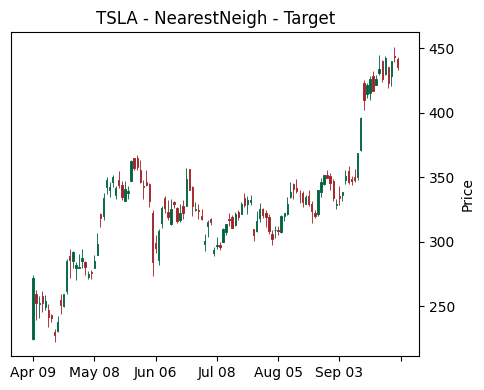

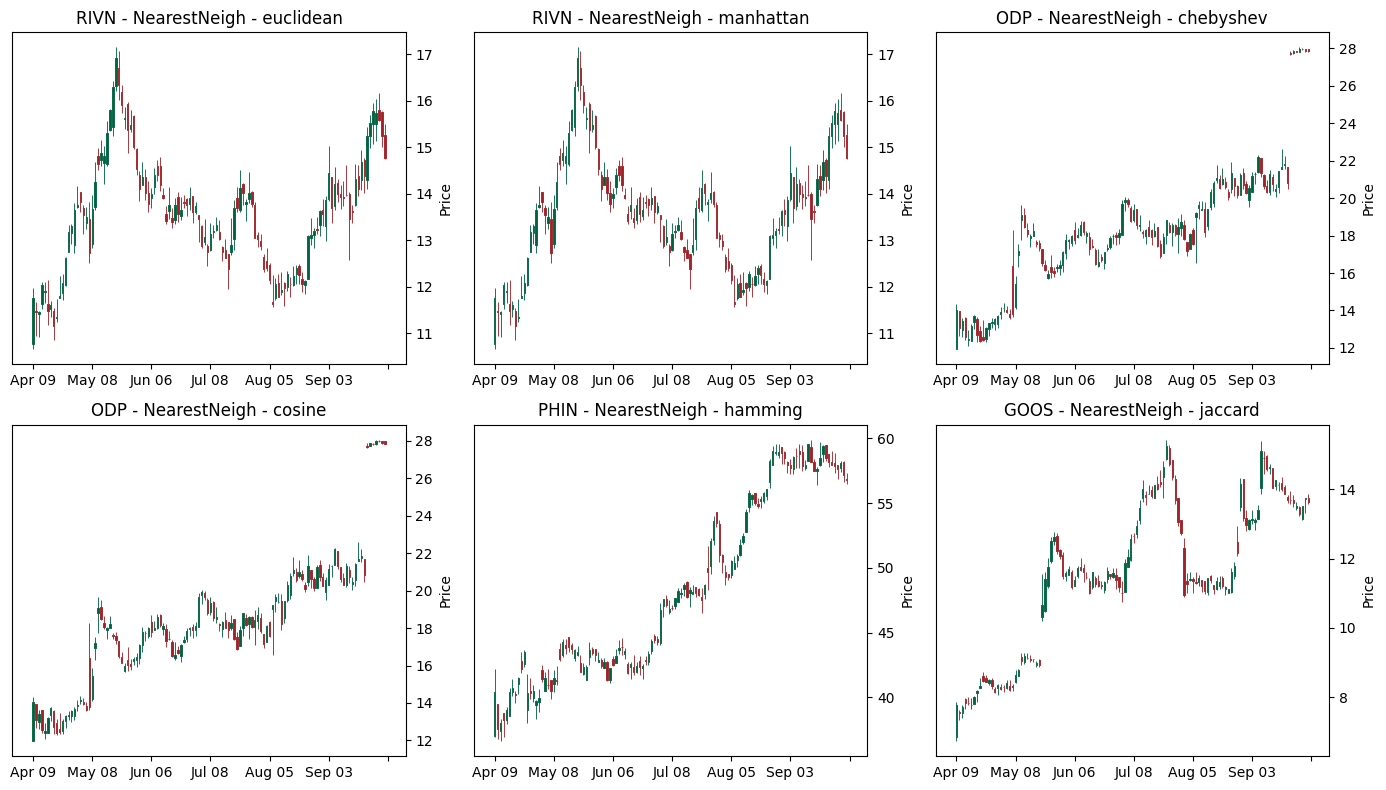

c:\Users\kenne\Dropbox\MS-DS Master Degree\Repo\CSCA55632_Final-Project\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
c:\Users\kenne\Dropbox\MS-DS Master Degree\Repo\CSCA55632_Final-Project\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
c:\Users\kenne\Dropbox\MS-DS Master Degree\Repo\CSCA55632_Final-Project\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
c:\Users\kenne\Dropbox\MS-DS Master Degree\Repo\CSCA55632_Final-Project\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
c:\Users\kenne\D

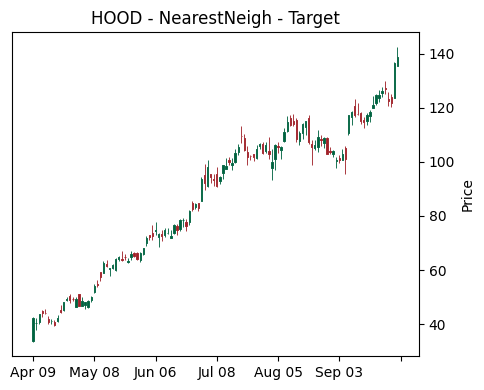

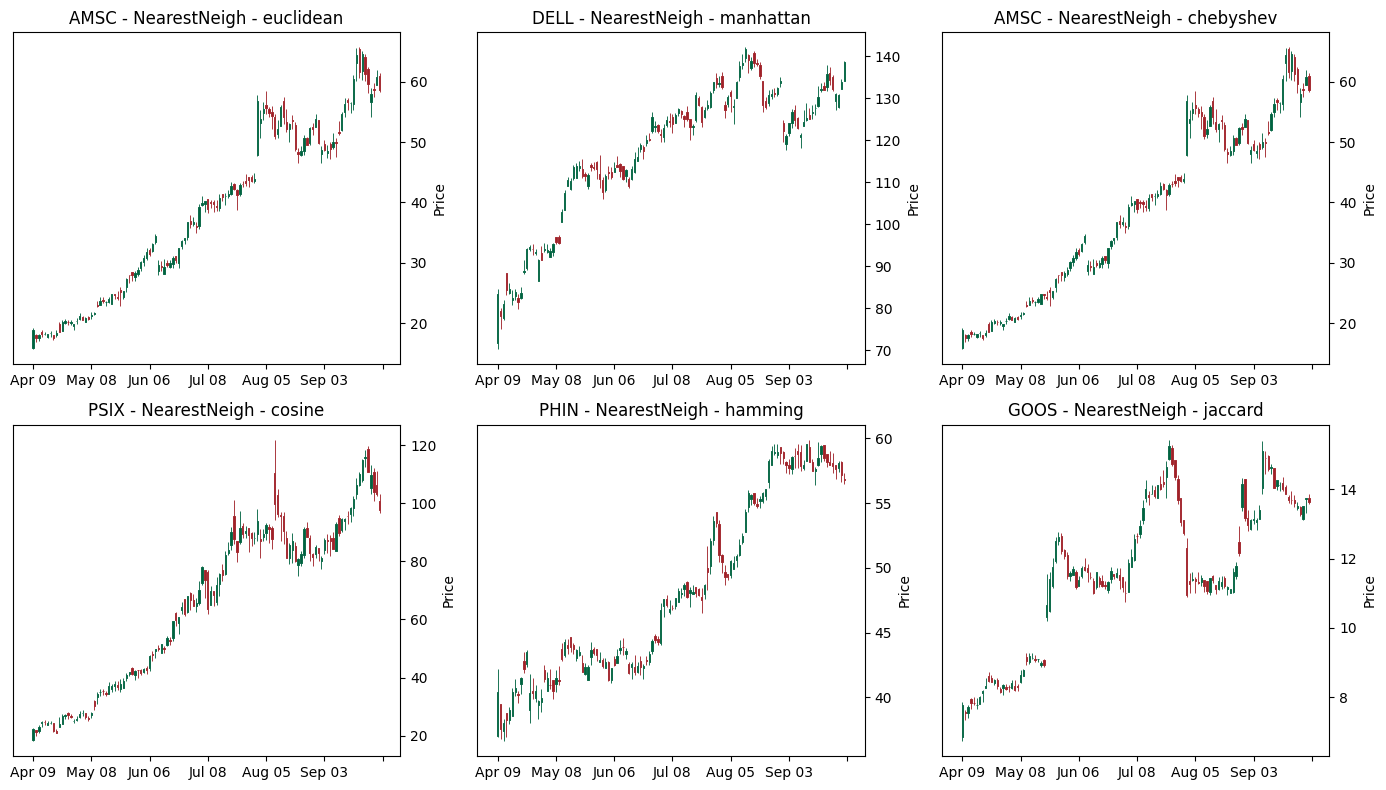

In [69]:
def plot_candlestick(tickers, tags,title_name,nr_cols=3):
    n = len(tickers)
    cols = nr_cols
    rows = math.ceil(n / nr_cols)
    
    fig, axes = plt.subplots(nrows=rows, ncols=nr_cols, figsize=(14, 4 * rows))
    axes = axes.flatten()

    for i, (ticker, tag) in enumerate(zip(tickers, tags)):
        ax = axes[i]
        df = pd.read_csv(f"data/{ticker}.csv", parse_dates=["Date"])
        df.set_index("Date", inplace=True)
        df = df[['Open', 'High', 'Low', 'Close']].tail(120)

        mpf.plot(
            df,
            type='candle',
            style='charles',
            ax=ax,
            volume=False,
            xrotation=0,
            ylabel='Price'
        )
        ax.set_title(f"{ticker} - {title_name} - {tag}")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

model_metrics = [
    'euclidean',
    'manhattan',
    'chebyshev',
    'cosine',
    'hamming',
    'jaccard'
]

target_tickers = ["TSLA","HOOD"]

for target_ticker in target_tickers:
    closest_tickers = []
    for model_metric in model_metrics:
        model = NearestNeighbors(
            n_neighbors=5,
            metric=model_metric,
            algorithm='auto',
            n_jobs=-1
        ).fit(X_pca)

        # Find similar stocks using KNN
        distances, indices = model.kneighbors([X_pca.loc[target_ticker]])
        KN_result = format_result_distance(distances)
        
        closest_ticker = KN_result['Ticker'][0]
        closest_tickers.append(closest_ticker)
        
    plot_candlestick ([target_ticker],['Target'],"NearestNeigh",nr_cols=3)
    plot_candlestick (closest_tickers,model_metrics,"NearestNeigh",nr_cols=3)
    

c:\Users\kenne\Dropbox\MS-DS Master Degree\Repo\CSCA55632_Final-Project\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


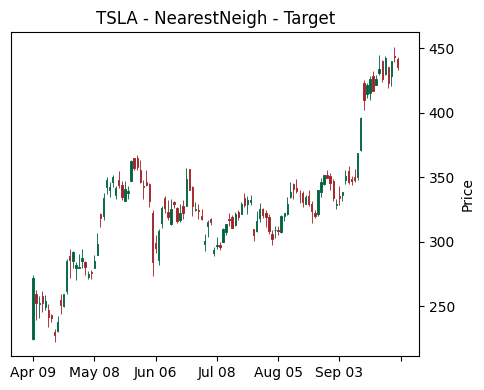

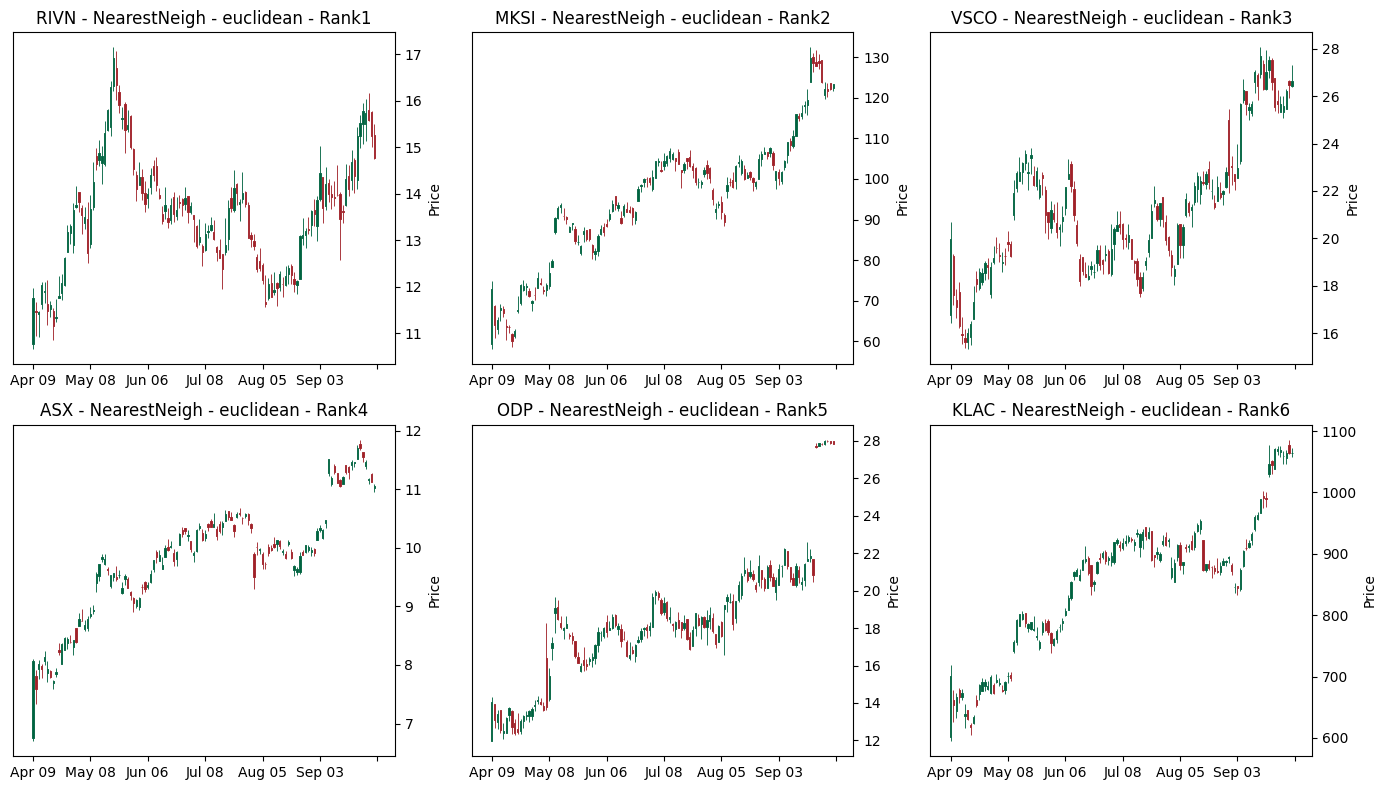

c:\Users\kenne\Dropbox\MS-DS Master Degree\Repo\CSCA55632_Final-Project\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


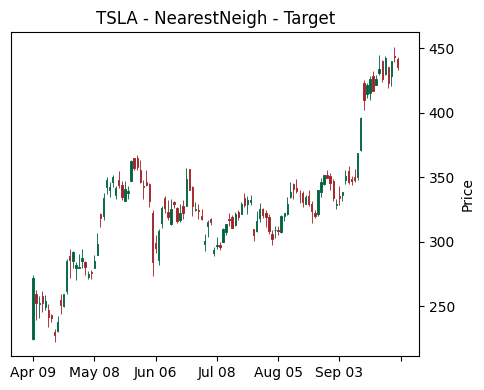

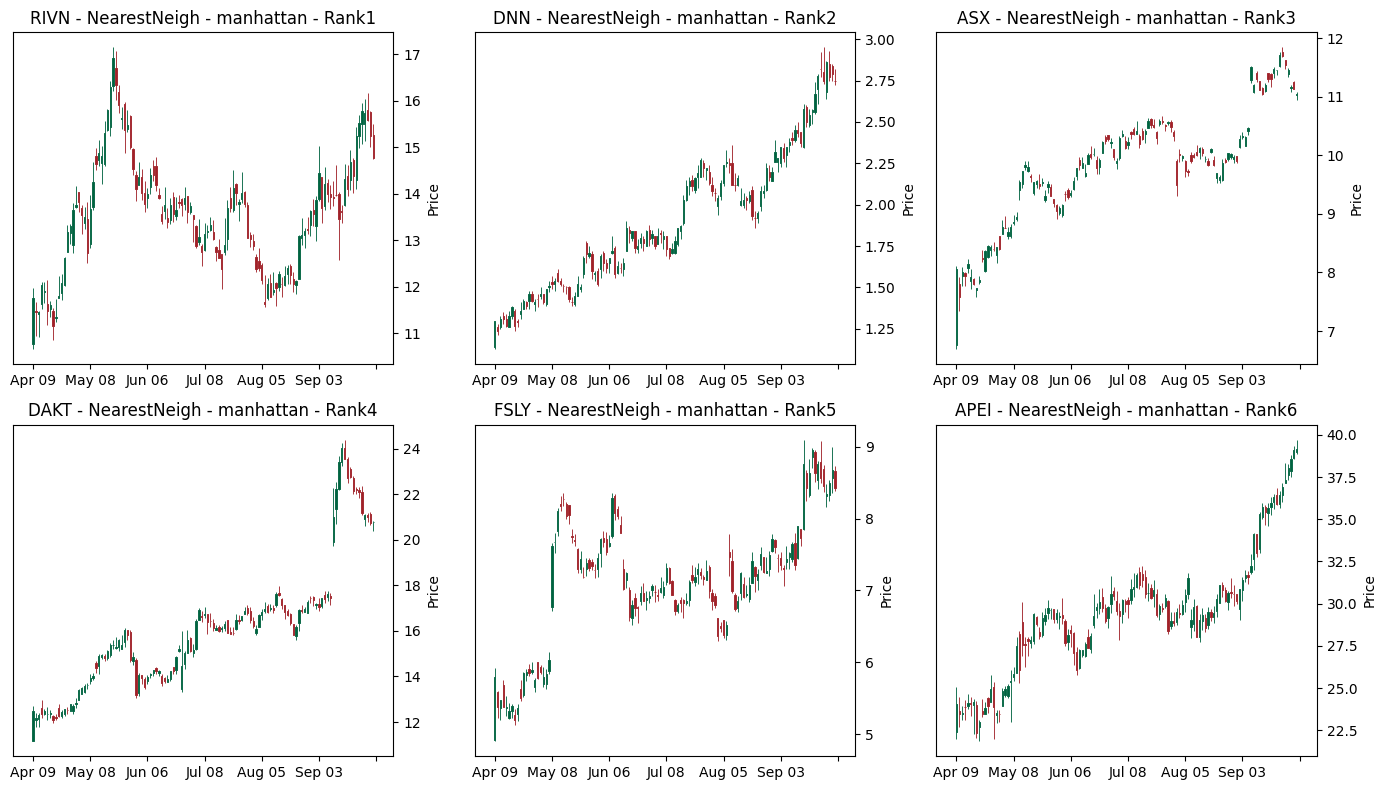

c:\Users\kenne\Dropbox\MS-DS Master Degree\Repo\CSCA55632_Final-Project\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


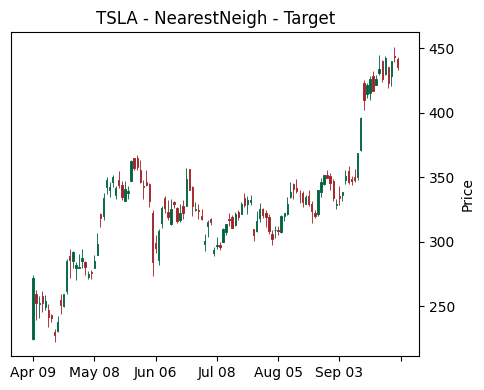

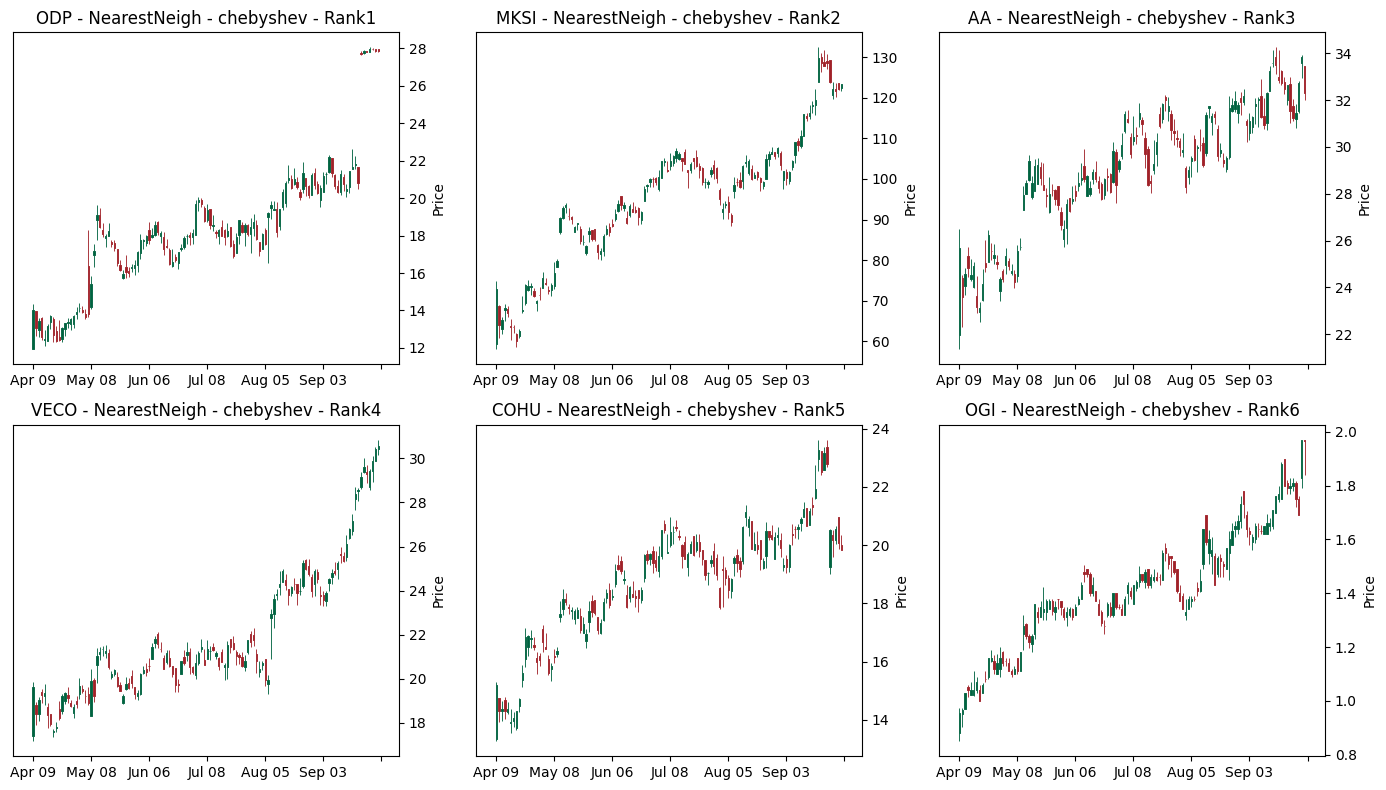

c:\Users\kenne\Dropbox\MS-DS Master Degree\Repo\CSCA55632_Final-Project\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


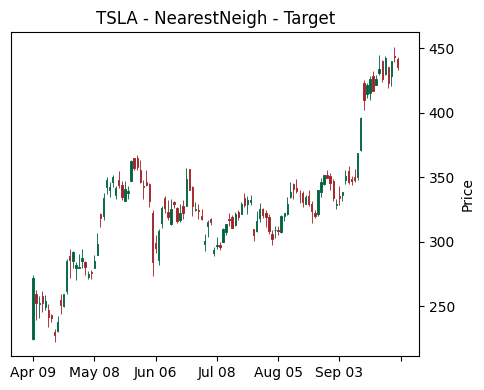

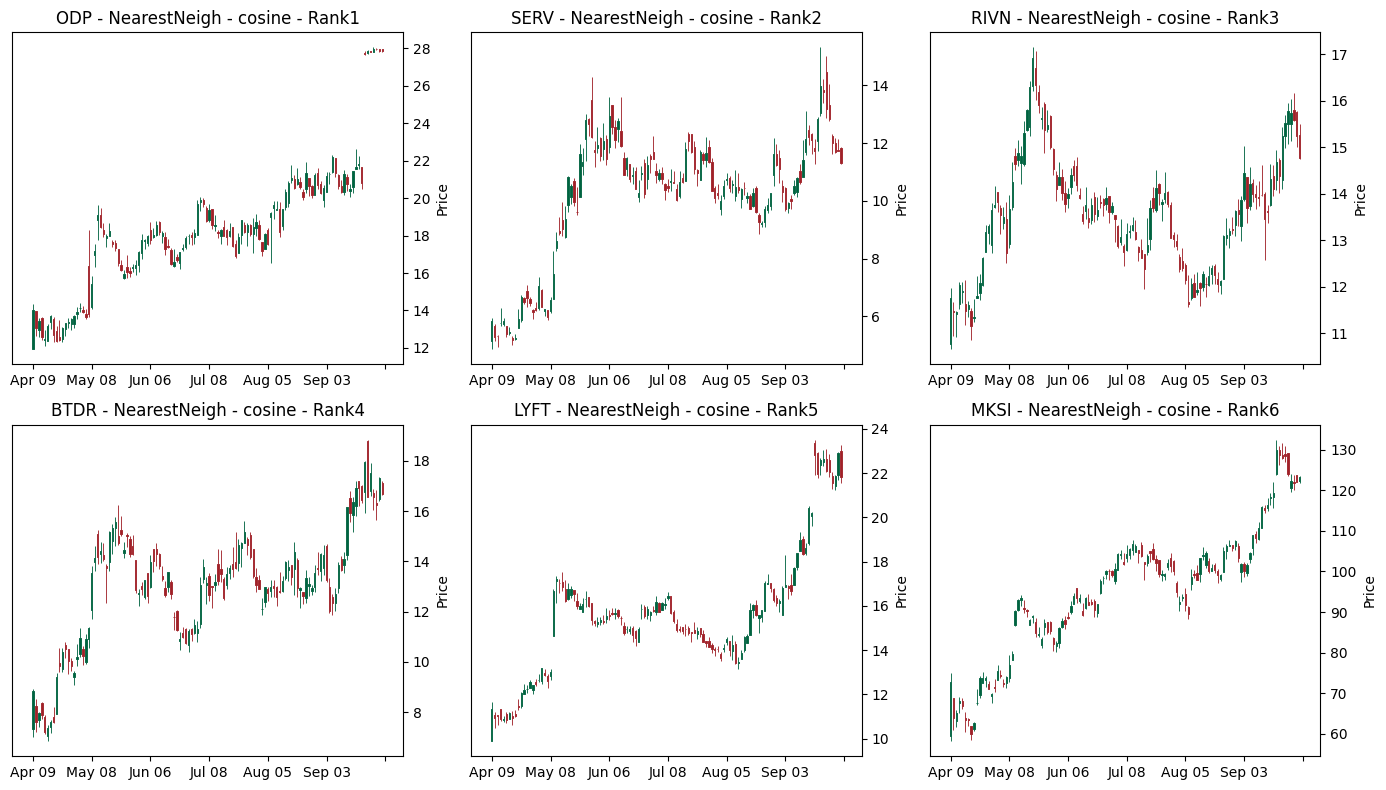

c:\Users\kenne\Dropbox\MS-DS Master Degree\Repo\CSCA55632_Final-Project\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


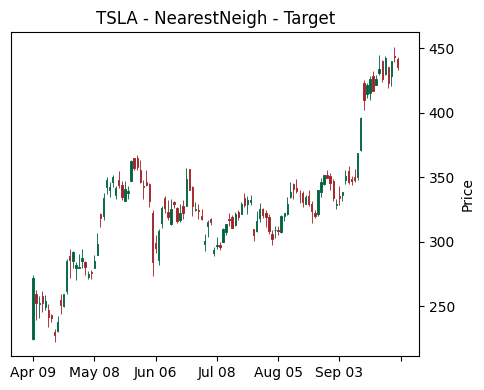

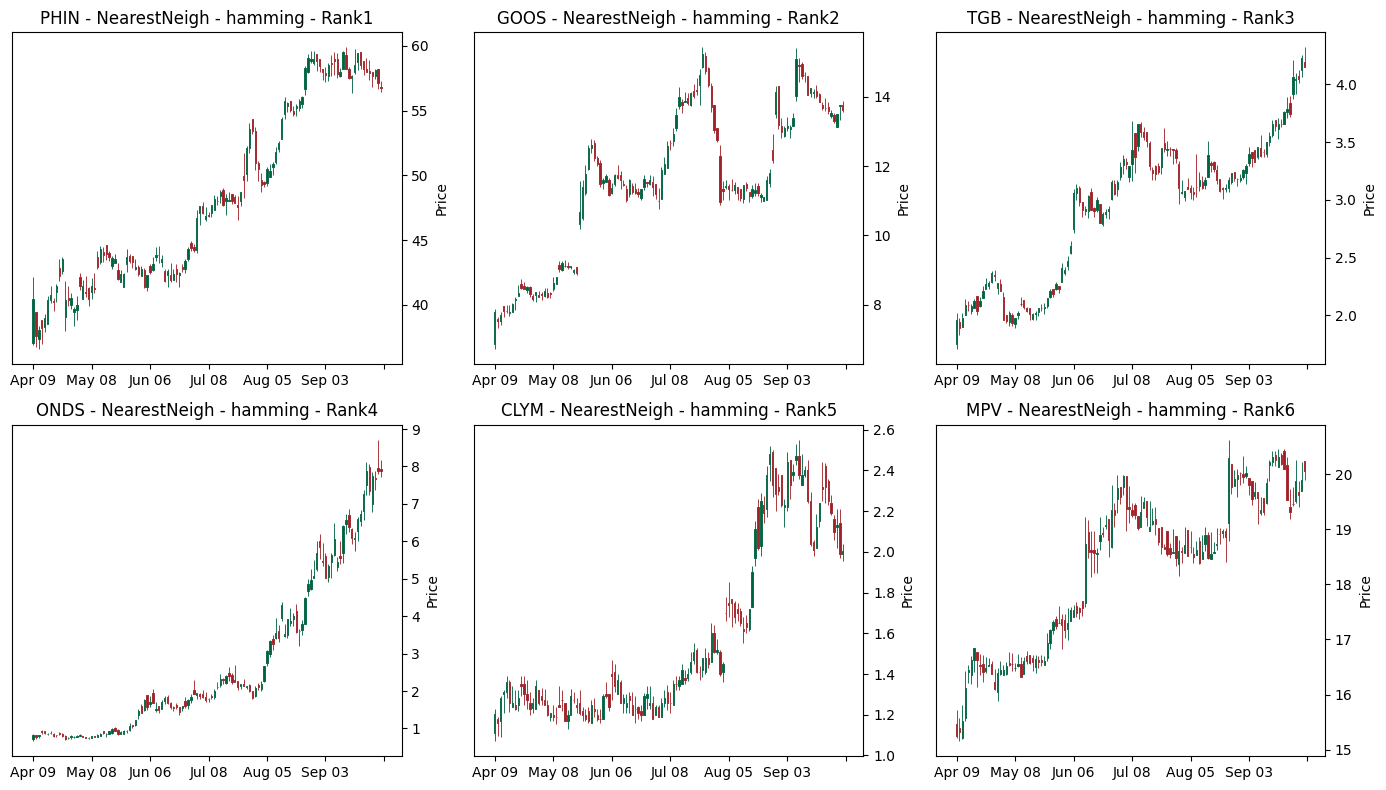

c:\Users\kenne\Dropbox\MS-DS Master Degree\Repo\CSCA55632_Final-Project\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
c:\Users\kenne\Dropbox\MS-DS Master Degree\Repo\CSCA55632_Final-Project\env\Lib\site-packages\sklearn\metrics\pairwise.py:2462: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


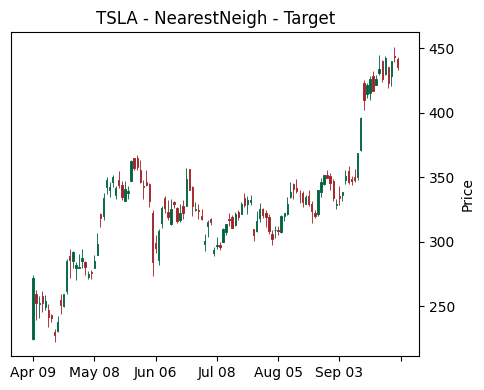

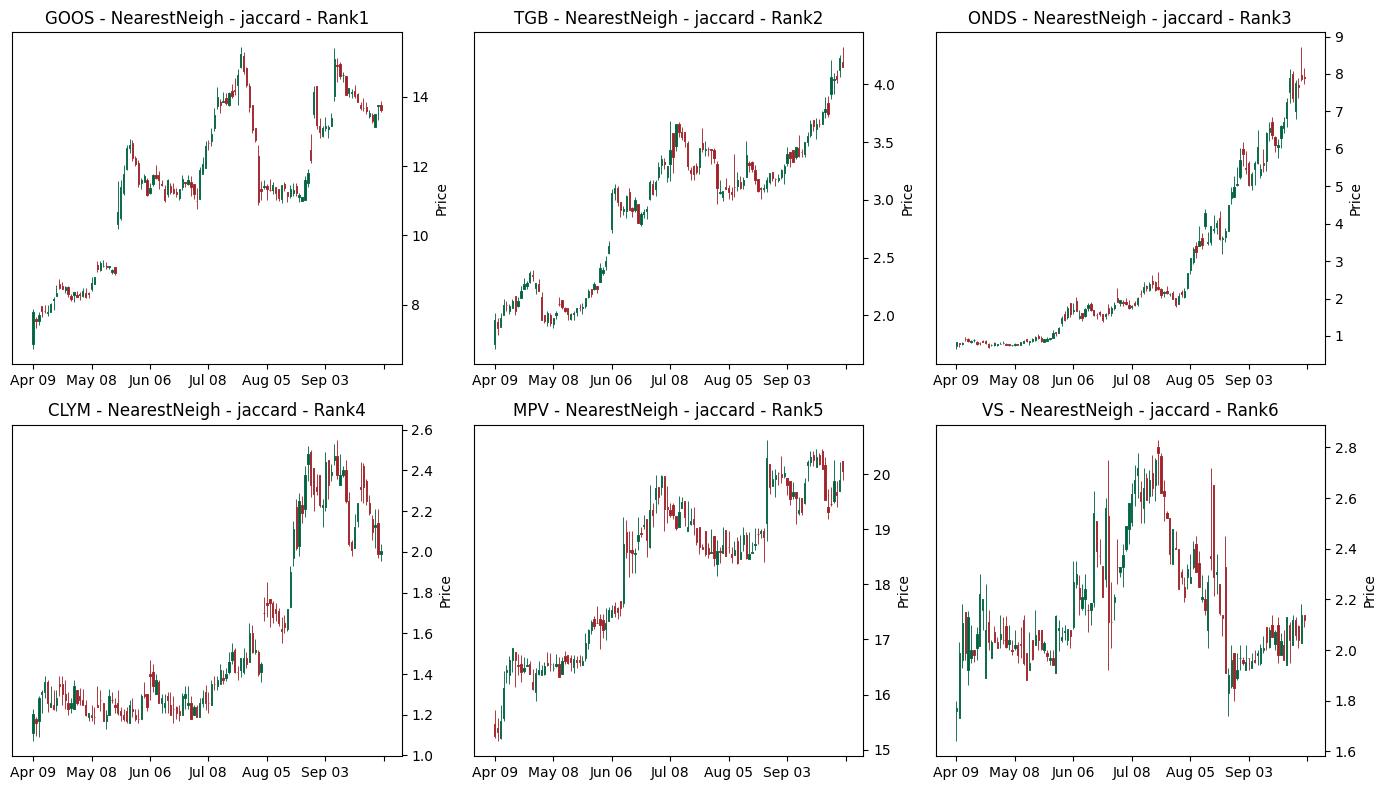

In [70]:
model_metrics = [
    'euclidean',
    'manhattan',
    'chebyshev',
    'cosine',
    'hamming',
    'jaccard'
]

target_tickers = ["TSLA"]
nr_most_similiar = 6

for target_ticker in target_tickers:
    for _metric in model_metrics:
        model = NearestNeighbors(
            n_neighbors=nr_most_similiar+1,
            metric=_metric,
            algorithm='auto',
            n_jobs=-1
        ).fit(X_pca)

        # Find similar stocks using KNN
        distances, indices = model.kneighbors([X_pca.loc[target_ticker]])
        KN_result = format_result_distance(distances)
        closest_tickers = KN_result['Ticker'][:nr_most_similiar+1]
            
        plot_candlestick ([target_ticker],['Target'],"NearestNeigh",nr_cols=3)
        plot_candlestick (closest_tickers,[f"{_metric} - Rank{i}" for i in range(1, nr_most_similiar+1)],"NearestNeigh",nr_cols=3)

SO which one is performing better? conclusion on model 1


#### 2nd Model - K Mean Clustering

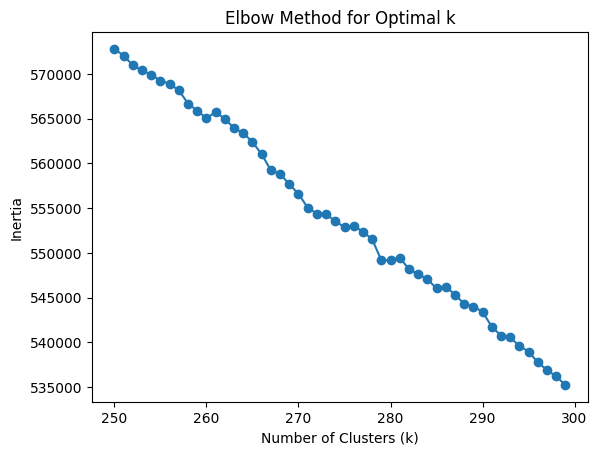

In [50]:
inertia = []
k_range = range(250, 300)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


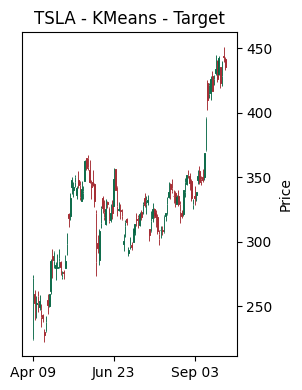

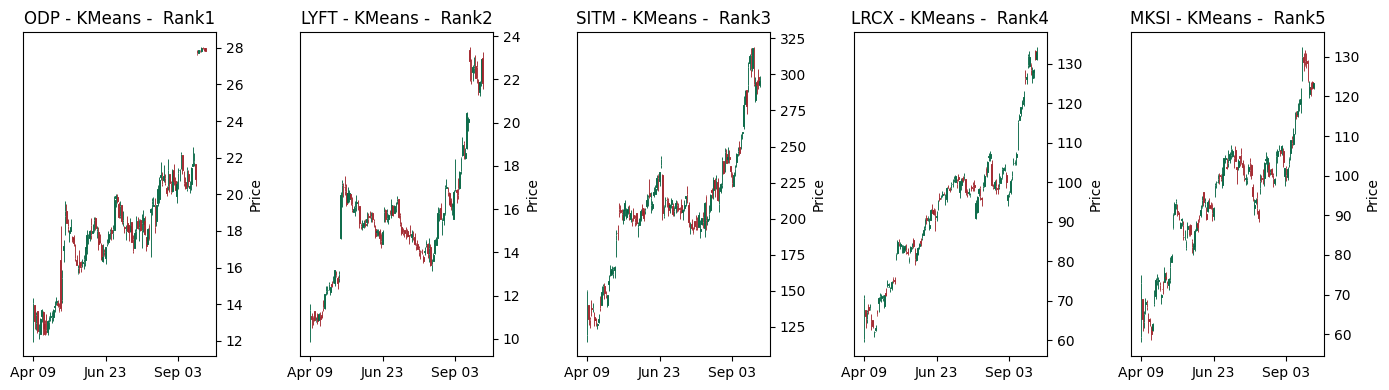

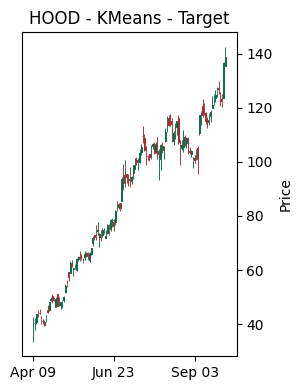

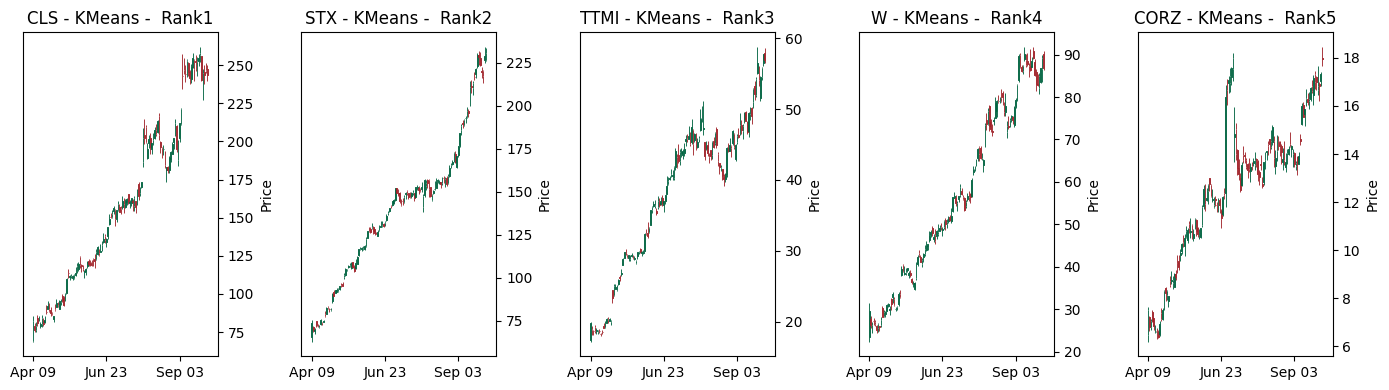

In [84]:
def evaluate_clustering(target_tickers,cluster_IDs,X_pca,title,nr_similar = 5):
    for target_ticker in target_tickers:
        target_index = X_pca.index.get_loc(target_ticker)
        my_cluster_Id = cluster_IDs[target_index]
        
        # Find all indices in the same cluster
        cluster_members_indices = []
        for i, cluster_id in enumerate(cluster_IDs):
            if cluster_id == my_cluster_Id:
                if i != target_index:
                    cluster_members_indices.append(i)

        if len(cluster_members_indices) == 0:
            nearest_tickers = []
        else:
            dists = cosine_distances([X_pca.iloc[target_index]], X_pca.iloc[cluster_members_indices])[0]
            
            sorted_tickers = [x for _, x in sorted(zip(dists, X_pca.iloc[cluster_members_indices].index))]
            nearest_tickers = sorted_tickers[:nr_similar]

        plot_candlestick ([target_ticker],['Target'],title,nr_cols=5)
        plot_candlestick (nearest_tickers,[f" Rank{i}" for i in range(1, nr_similar+1)],title,nr_cols=5)

k = 278
nr_most_similiar = 5
pca_components = 20
X_pca = pca_transform(X, pca_components)

kmeans = KMeans(n_clusters=k, random_state=42)
cluster_IDs = kmeans.fit_predict(X_pca)

target_tickers = ["TSLA","HOOD"]
evaluate_clustering(target_tickers,cluster_IDs,X_pca,"KMeans",nr_similar= nr_most_similiar)

K-Means clustering with no clear inflection point

#### 3rd Model - Hierarchical Clustering (Agglomerative)

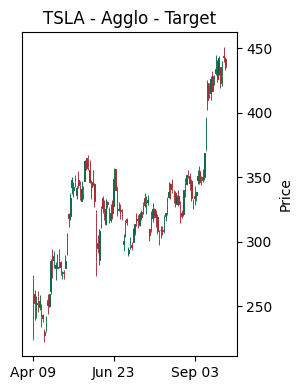

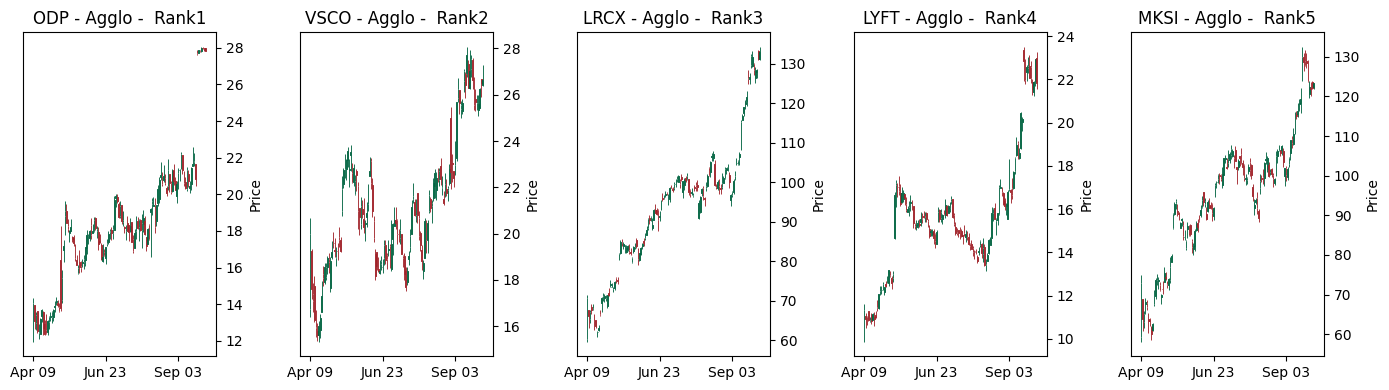

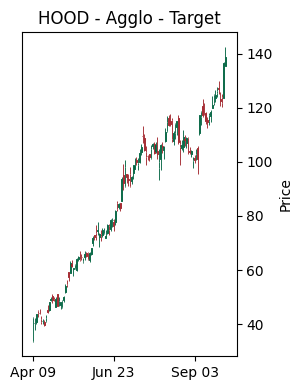

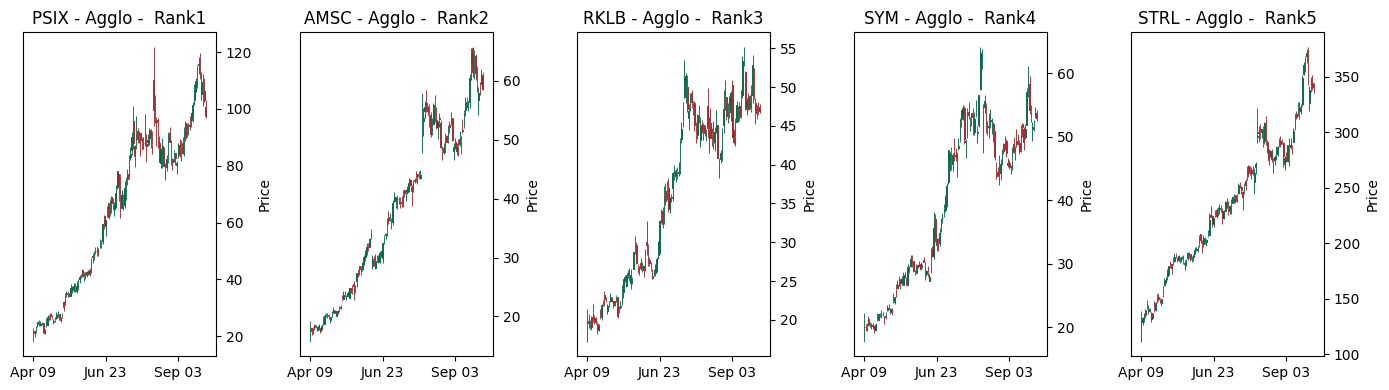

In [88]:
nr_most_similiar = 5
pca_components = 30
X_pca = pca_transform(X, pca_components)

model = AgglomerativeClustering(
    distance_threshold=1,
    n_clusters=None, 
    metric='cosine',
    linkage='average'
)
cluster_IDs = model.fit_predict(X_pca)

target_tickers = ["TSLA","HOOD"]
evaluate_clustering(target_tickers,cluster_IDs,X_pca,"Agglo",nr_similar= nr_most_similiar)


Hyperparameter tuning

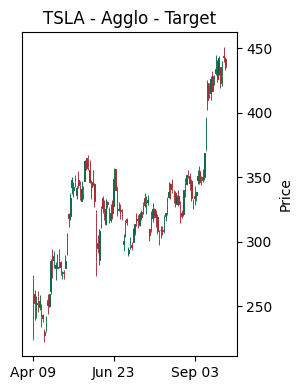

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1400x0 with 0 Axes>

In [ ]:
# from sklearn.metrics import pairwise_distances

nr_most_similiar = 2
pca_components = [20]

linkages = [
    'ward',
    'average',
    'complete',
    'single',   
]

metrics = [
    'euclidean',
    'manhattan',
    'l1',
    'l2',
    'chebyshev',
    'cosine',
]

for pca_component in pca_components:
    for _linkage in linkages:
        for _metric in metrics:
            
            if _linkage == 'ward' and _metric != 'euclidean':
                continue
            
            X_pca = pca_transform(X, pca_component)

            model = AgglomerativeClustering(
                distance_threshold=1,
                n_clusters=None, 
                metric=_metric,
                linkage=_linkage
            )
            cluster_IDs = model.fit_predict(X_pca)

            target_tickers = ["TSLA"]
            evaluate_clustering(target_tickers,cluster_IDs,X_pca,"Agglo",nr_similar= nr_most_similiar)



## 6 Results & Analysis
### <span style="color:rgba(109, 0, 0, 1)">6.1 Summary of results on models</span>

### <span style="color:rgba(109, 0, 0, 1)">6.2 Iteration on improving performance</span>

### <span style="color:rgba(109, 0, 0, 1)">6.3 Dicussion on model performance</span>

## 7 Discussion & Conclusion
### <span style="color:rgba(109, 0, 0, 1)">7.1 Learning & Take-aways</span>

### <span style="color:rgba(109, 0, 0, 1)">7.2 Challenges and Problems</span>

### <span style="color:rgba(109, 0, 0, 1)">7.3 Suggestions & Improvements</span>